In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
import re
import seaborn as sns
from scipy.stats import fisher_exact

# import functions.py
import functions as fun

In [2]:
seed = 0
torch.manual_seed(seed)            
torch.cuda.manual_seed(seed)    
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)

In [3]:
# read training and dev data
train_data = fun.pd_data(file = 'SUD_English-GUM/en_gum-sud-train.conllu')
valid_data = fun.pd_data(file = 'SUD_English-GUM/en_gum-sud-dev.conllu')

In [4]:
# Single features
# Number agreement
train_data_number = fun.gender_number_person_data(train_data, gender = False, number = True, person = False)
valid_data_number = fun.gender_number_person_data(valid_data, gender = False, number = True, person = False)

# Gender agreement
train_data_gender = fun.gender_number_person_data(train_data,  gender = True, number = False, person = False)
valid_data_gender = train_data_gender.iloc[:,:6]#fun.gender_number_person_data(valid_data, gender = True, number = False, person = False)

# Person agreement
train_data_person = fun.gender_number_person_data(train_data,  gender = False, number = False, person = True)
valid_data_person = fun.gender_number_person_data(valid_data, gender = False, number = False, person = True)


# All the features exists same time
train_data_all = fun.gender_number_person_data(train_data, gender = True, number = True, person = True)
valid_data_all = train_data_all.iloc[:,:6]#fun.gender_number_person_data(valid_data, gender = True, number = True, person = True)

In [6]:
# Let every feature be in one column
# Single features
# Number agreement
train_data_number_feature = fun.seperate_feature_in_one_column (train_data_number)
valid_data_number_feature = fun.seperate_feature_in_one_column (valid_data_number)

# Gender agreement
train_data_gender_feature = fun.seperate_feature_in_one_column (train_data_gender)
valid_data_gender_feature = fun.seperate_feature_in_one_column (valid_data_gender)

# Person agreement
train_data_person_feature = fun.seperate_feature_in_one_column (train_data_person)
valid_data_person_feature = fun.seperate_feature_in_one_column (valid_data_person)

# All the features exists same time
train_data_all_feature = fun.seperate_feature_in_one_column (train_data_all)
valid_data_all_feature = fun.seperate_feature_in_one_column (valid_data_all)

In [7]:
# finding unique features 
# finding unique category among features

# Single features
# Number agreement
feature_number = fun.unique_features(train_data_number_feature)
feature_valid_number = fun.unique_features(valid_data_number_feature)

category_number = fun.unique_category(feature_number)
category_valid_number = fun.unique_category(feature_valid_number)

# Gender agreement

feature_gender = fun.unique_features(train_data_gender_feature)
feature_valid_gender = fun.unique_features(valid_data_gender_feature)

category_gender = fun.unique_category(feature_gender)
category_valid_gender = fun.unique_category(feature_valid_gender)

# Person agreement

feature_person = fun.unique_features(train_data_person_feature)
feature_valid_person = fun.unique_features(valid_data_person_feature)

category_person = fun.unique_category(feature_person)
category_valid_person = fun.unique_category(feature_valid_person)

# All the features exists same time

feature_all = fun.unique_features(train_data_all_feature)
feature_valid_all = fun.unique_features(valid_data_all_feature)

category_all = fun.unique_category(feature_all)
category_valid_all = fun.unique_category(feature_valid_all)

In [8]:
# Single features
# Number agreement
# Let every column only have one feature
train_data_number_ff = fun.final_train_feature(train_data_number,category_number)
valid_data_number_ff = fun.final_train_feature(valid_data_number,category_valid_number)
# Filter features columns we need
train_number = fun.filter_feature(train_data_number_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Number_head','Number_mod'])
valid_number = fun.filter_feature(valid_data_number_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Number_head','Number_mod'])

# Gender agreement
# Let every column only have one feature
train_data_gender_ff = fun.final_train_feature(train_data_gender,category_gender)
valid_data_gender_ff = fun.final_train_feature(valid_data_gender,category_valid_gender)
# Filter features columns we need
train_gender = fun.filter_feature(train_data_gender_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Gender_head','Gender_mod'])
valid_gender = fun.filter_feature(valid_data_gender_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Gender_head','Gender_mod'])

# Person agreement
# Let every column only have one feature
train_data_person_ff = fun.final_train_feature(train_data_person,category_person)
valid_data_person_ff = fun.final_train_feature(valid_data_person,category_valid_person)
# Filter features columns we need
train_person = fun.filter_feature(train_data_person_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Person_head','Person_mod'])
valid_person = fun.filter_feature(valid_data_person_ff, ['POS_HEAD', 'POS_MOD', 'RELATION', 'Person_head','Person_mod'])

# # All the features exists same time
train_data_all_ff = fun.final_train_feature(train_data_all,category_all)
valid_data_all_ff = fun.final_train_feature(valid_data_all,category_valid_all)
# Filter features columns we need
train_all = fun.filter_feature(train_data_all_ff)
valid_all = fun.filter_feature(valid_data_all_ff)

In [9]:
# All the possible labels

label = {'POS':['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'],
'RELATION':['subj', 'mod', 'comp', 'comp:obj', 'comp:obl', 'comp:aux', 'comp:pred', 'udep', 'unk','vocative', 'dislocated', 'discourse', 'appos', 'det', 
'clf', 'conj', 'cc', 'flat','compound', 'list', 'parataxis', 'orphan', 'goeswith', 'reparandum', 'punct'], 'Person':['1', '2', '3'],       
'Gender':['Fem', 'Masc'],'Number':[ 'Plur', 'Sing']}


In [10]:
# Change the Relation labels to the exsiting above Relation labels
# remove @

# Number agreement
train_number = fun.cleaning_relation_labels(train_number)
valid_number = fun.cleaning_relation_labels(valid_number)

# Gender agreement
train_gender = fun.cleaning_relation_labels(train_gender)
valid_gender = fun.cleaning_relation_labels(valid_gender)

# Person agreement
train_person = fun.cleaning_relation_labels(train_person)
valid_person = fun.cleaning_relation_labels(valid_person)

# All the features exists same time
train_all = fun.cleaning_relation_labels(train_all)
valid_all = fun.cleaning_relation_labels(valid_all)


In [16]:
# Achieve final inputs (onehot encoding)

# Number agreement
# Dict
discrete_dict_number, binary_dict_number, re_classes_number = fun.achieve_input_dict(label,train_number[['POS_HEAD', 'POS_MOD', 'RELATION']])
valid_discrete_dict_number, valid_binary_dict_number, valid_re_classes_number = fun.achieve_input_dict(label,valid_number[['POS_HEAD', 'POS_MOD', 'RELATION']])
# Array
len_discrete_number, discrete_number, len_bianry_number, binary_number = fun.achive_input_array(discrete_dict_number, binary_dict_number)
valid_len_discrete_number, valid_discrete_number, valid_len_bianry_number, valid_binary_number = fun.achive_input_array(valid_discrete_dict_number, valid_binary_dict_number)

# Gender agreement
# Dict
discrete_dict_gender, binary_dict_gender, re_classes_gender = fun.achieve_input_dict(label,train_gender[['POS_HEAD', 'POS_MOD', 'RELATION']])
valid_discrete_dict_gender, valid_binary_dict_gender, valid_re_classes_gender = fun.achieve_input_dict(label,valid_gender[['POS_HEAD', 'POS_MOD', 'RELATION']])
# Array
len_discrete_gender, discrete_gender, len_bianry_gender, binary_gender = fun.achive_input_array(discrete_dict_gender, binary_dict_gender)
valid_len_discrete_gender, valid_discrete_gender, valid_len_bianry_gender, valid_binary_gender = fun.achive_input_array(valid_discrete_dict_gender, valid_binary_dict_gender)

# Person agreement
# Dict
discrete_dict_person, binary_dict_person, re_classes_person = fun.achieve_input_dict(label,train_person[['POS_HEAD', 'POS_MOD', 'RELATION']])
valid_discrete_dict_person, valid_binary_dict_person, valid_re_classes_person = fun.achieve_input_dict(label,valid_person[['POS_HEAD', 'POS_MOD', 'RELATION']])
# Array
len_discrete_person, discrete_person, len_bianry_person, binary_person = fun.achive_input_array(discrete_dict_person, binary_dict_person)
valid_len_discrete_person, valid_discrete_person, valid_len_bianry_person, valid_binary_person = fun.achive_input_array(valid_discrete_dict_person, valid_binary_dict_person)

# All the features exists same time
# Dict
discrete_dict_all, binary_dict_all, re_classes_all = fun.achieve_input_dict(label,train_all[['POS_HEAD', 'POS_MOD', 'RELATION']])
valid_discrete_dict_all, valid_binary_dict_all, valid_re_classes_all = fun.achieve_input_dict(label,valid_all[['POS_HEAD', 'POS_MOD', 'RELATION']])
# Array
len_discrete_all, discrete_all, len_bianry_all, binary_all = fun.achive_input_array(discrete_dict_all, binary_dict_all)
valid_len_discrete_all, valid_discrete_all, valid_len_bianry_all, valid_binary_all = fun.achive_input_array(valid_discrete_dict_all, valid_binary_dict_all)


In [17]:
# Feature Agreement as input  (reach agreement 1; not reach agreement 0)

# Number agreement
number_agreement = torch.tensor(fun.agreement(train_number['Number_head'],train_number['Number_mod'])).reshape(-1,1)
valid_number_agreement = torch.tensor(fun.agreement(valid_number['Number_head'],valid_number['Number_mod'])).reshape(-1,1)

# Gender agreement
gender_agreement = torch.tensor(fun.agreement(train_gender['Gender_head'],train_gender['Gender_mod'])).reshape(-1,1)
valid_gender_agreement = torch.tensor(fun.agreement(valid_gender['Gender_head'],valid_gender['Gender_mod'])).reshape(-1,1)

# Person agreement
person_agreement = torch.tensor(fun.agreement(train_person['Person_head'],train_person['Person_mod'])).reshape(-1,1)
valid_person_agreement = torch.tensor(fun.agreement(valid_person['Person_head'],valid_person['Person_mod'])).reshape(-1,1)

# All the features exists same time
all_agreement = fun.all_agreement(train_all).reshape(-1,1)
valid_all_agreement = fun.all_agreement(valid_all).reshape(-1,1)



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number agreement, 1 latent variable


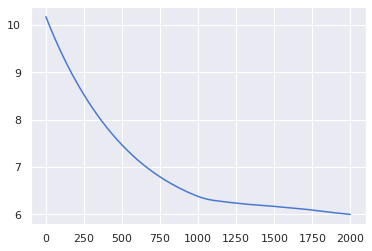

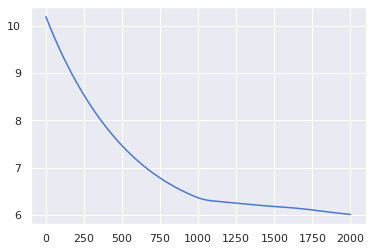

Gender agreement, 1 latent variable


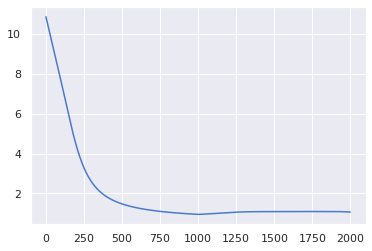

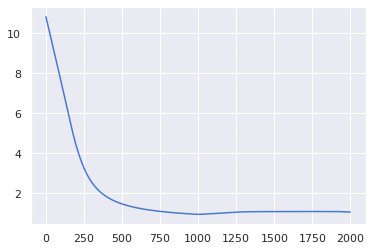

Person agreement, 1 latent variable


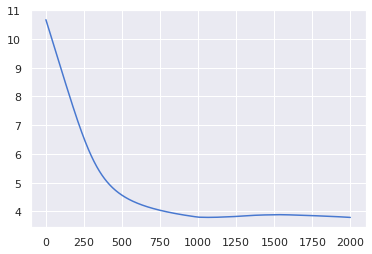

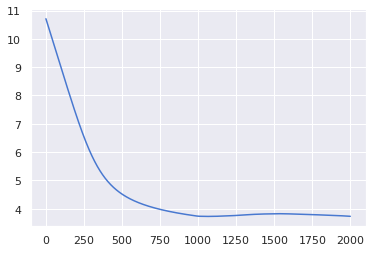

Number agreement, 1 latent variable


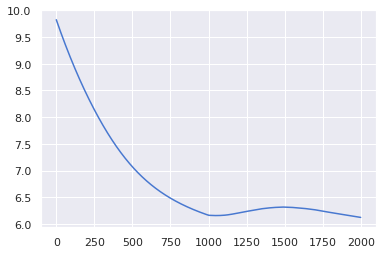

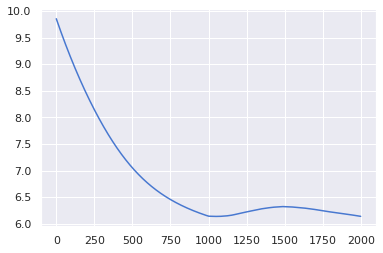

Gender agreement, 1 latent variable


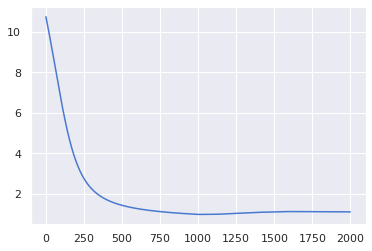

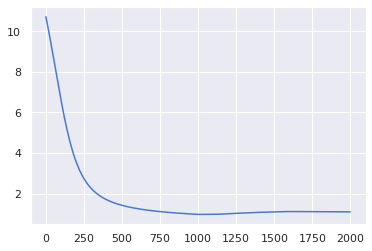

Person agreement, 1 latent variable


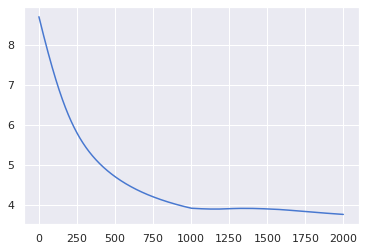

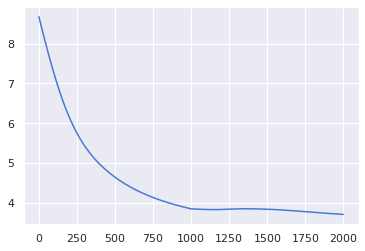

Number agreement, 1 latent variable


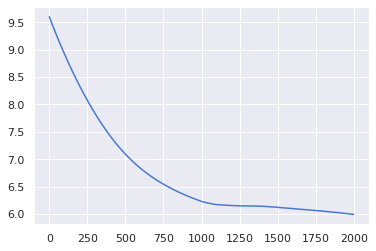

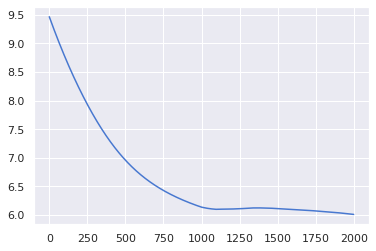

Gender agreement, 1 latent variable


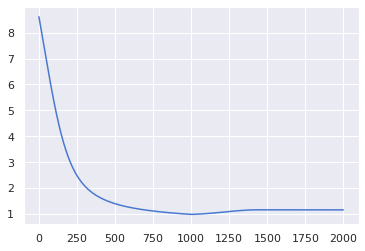

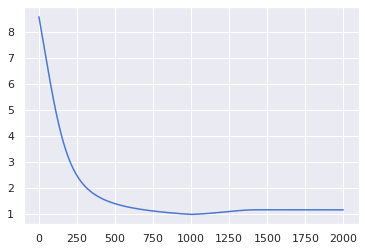

Person agreement, 1 latent variable


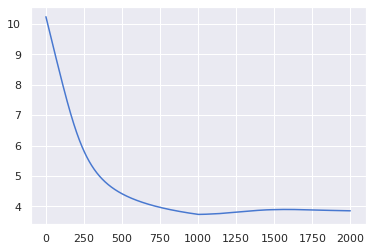

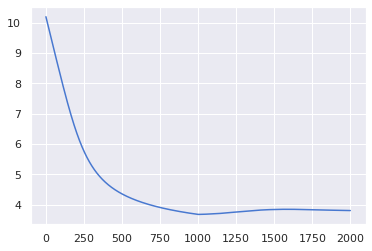

Number agreement, 1 latent variable


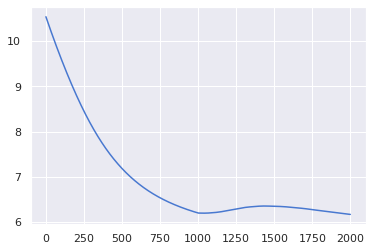

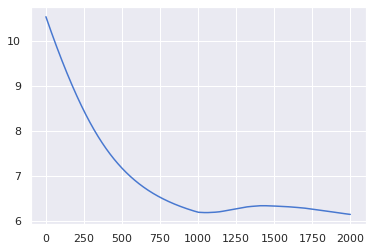

Gender agreement, 1 latent variable


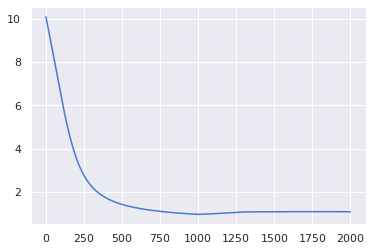

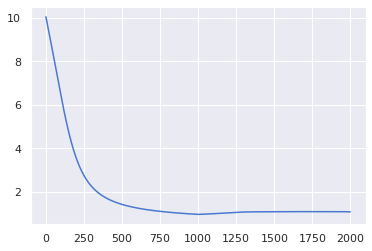

Person agreement, 1 latent variable


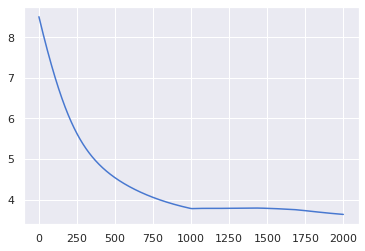

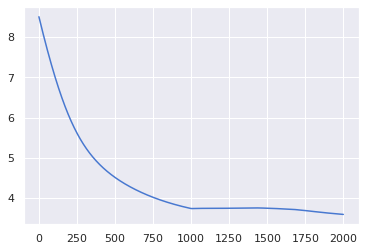

Number agreement, 1 latent variable


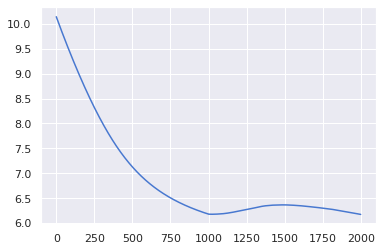

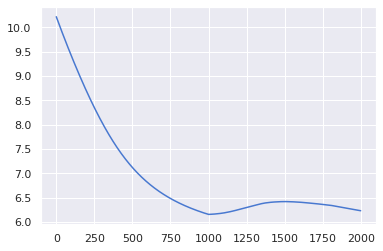

Gender agreement, 1 latent variable


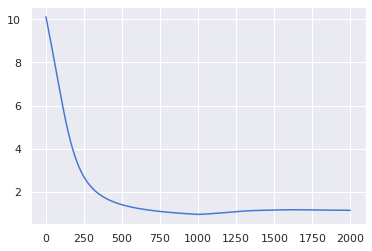

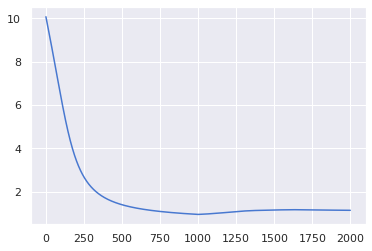

Person agreement, 1 latent variable


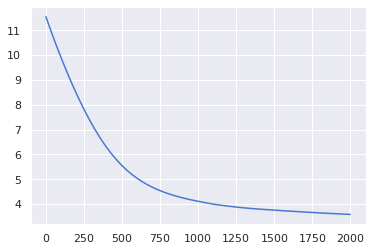

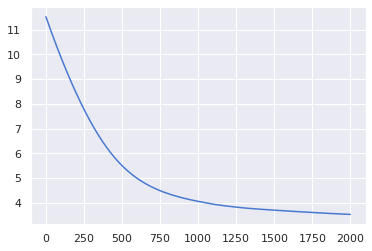

Number agreement, 1 latent variable


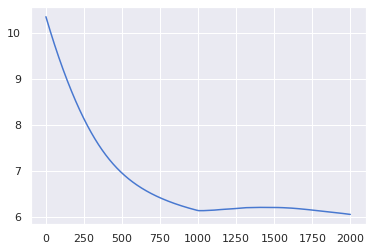

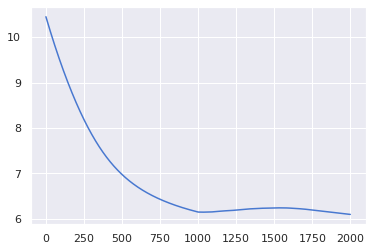

Gender agreement, 1 latent variable


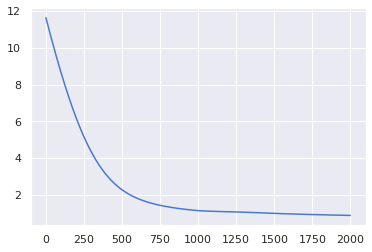

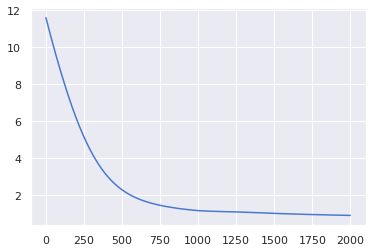

Person agreement, 1 latent variable


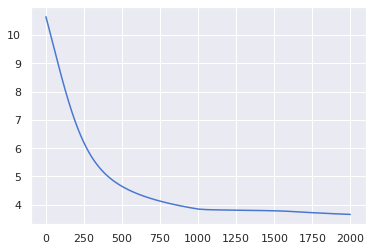

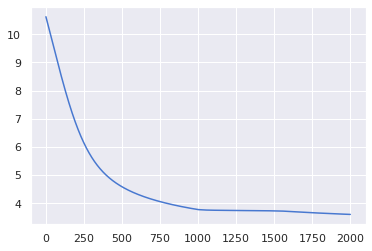

Number agreement, 1 latent variable


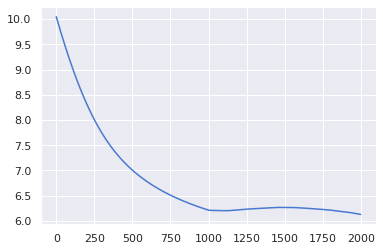

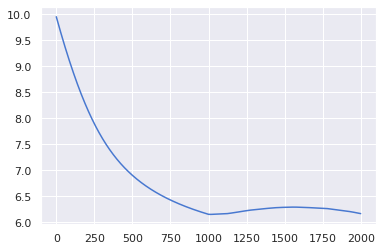

Gender agreement, 1 latent variable


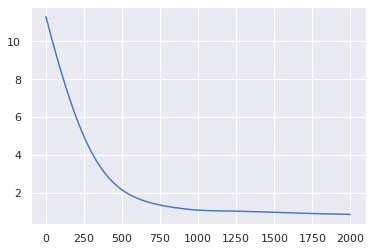

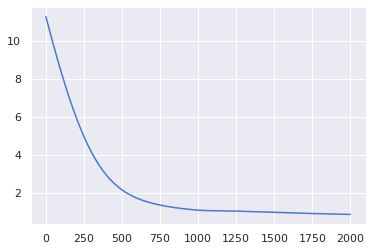

Person agreement, 1 latent variable


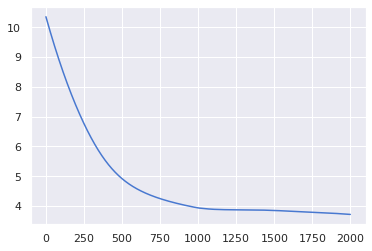

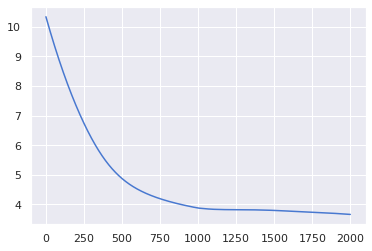

Number agreement, 1 latent variable


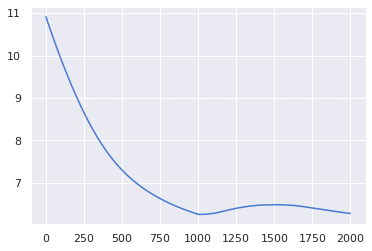

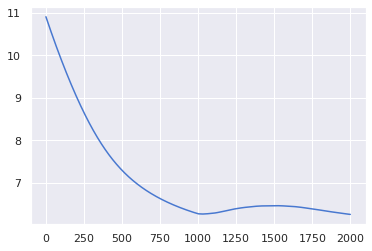

Gender agreement, 1 latent variable


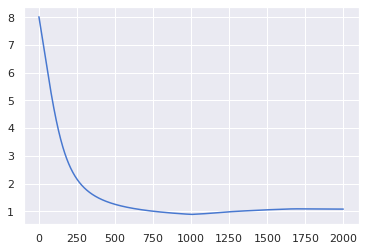

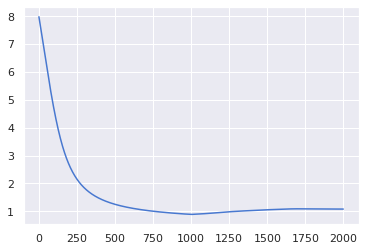

Person agreement, 1 latent variable


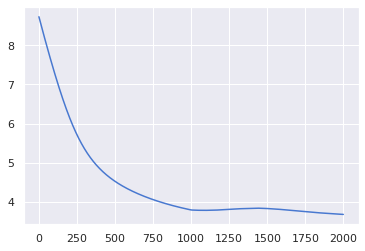

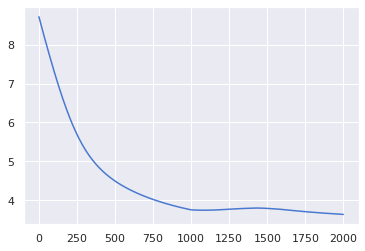

Number agreement, 1 latent variable


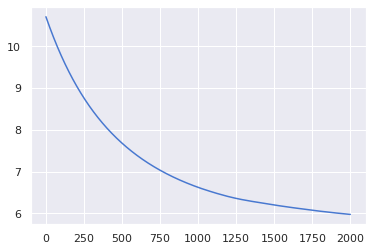

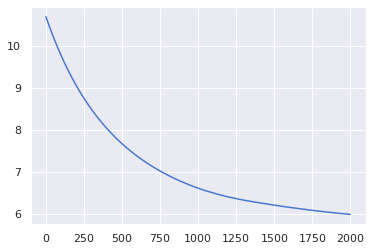

Gender agreement, 1 latent variable


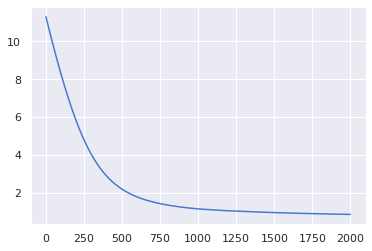

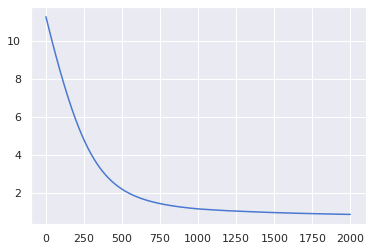

Person agreement, 1 latent variable


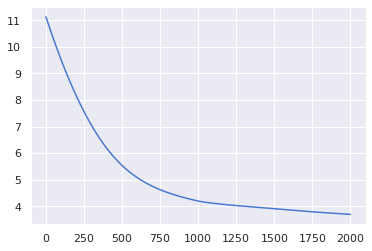

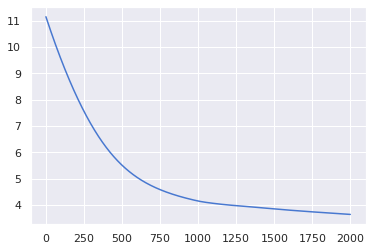

Number agreement, 1 latent variable


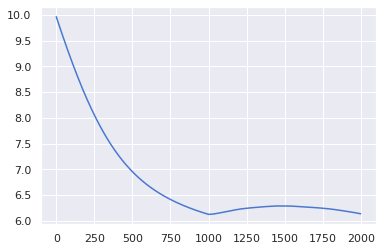

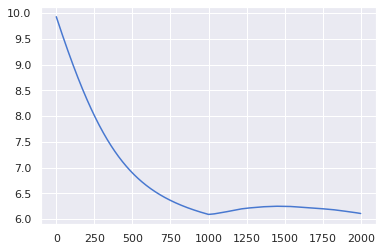

Gender agreement, 1 latent variable


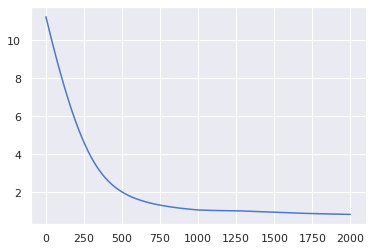

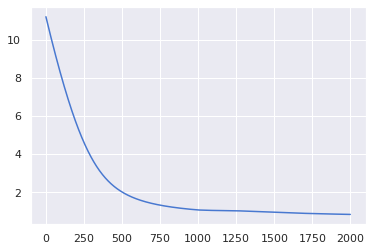

Person agreement, 1 latent variable


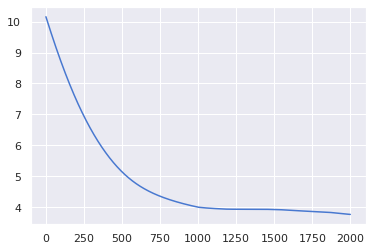

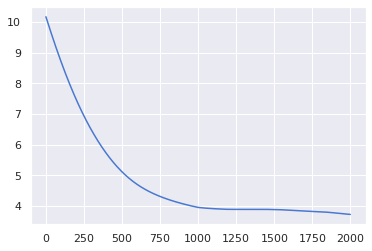

Number agreement, 1 latent variable


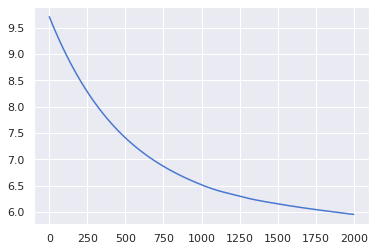

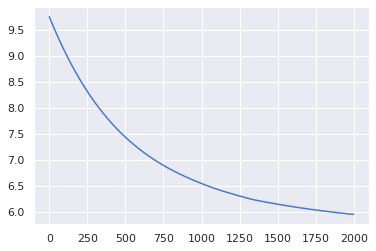

Gender agreement, 1 latent variable


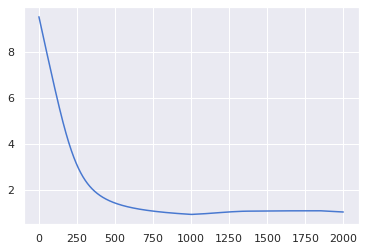

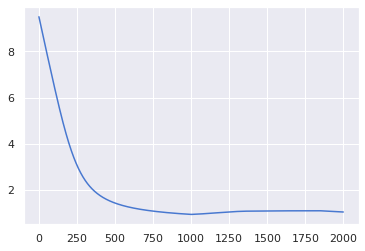

Person agreement, 1 latent variable


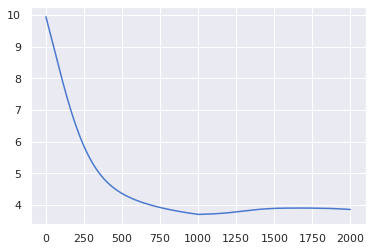

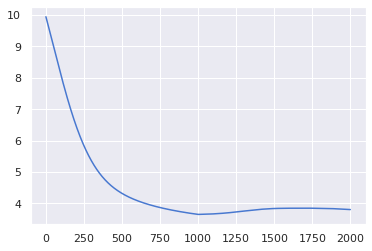

Number agreement, 1 latent variable


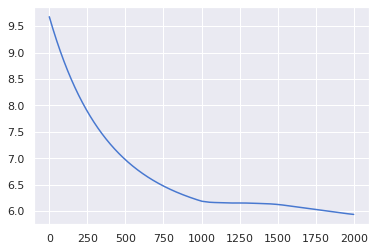

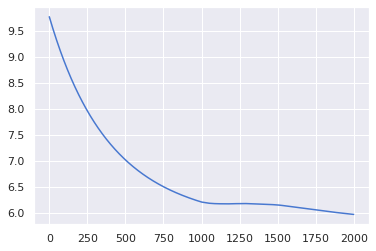

Gender agreement, 1 latent variable


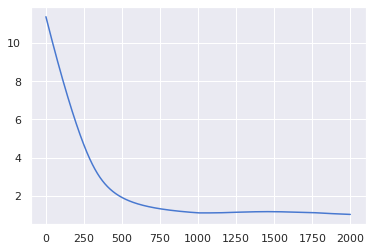

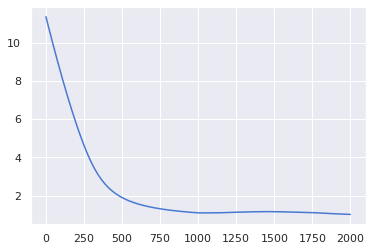

Person agreement, 1 latent variable


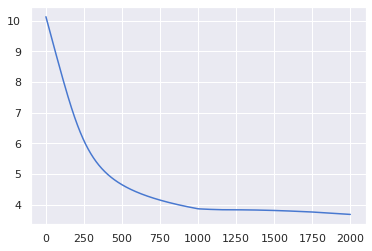

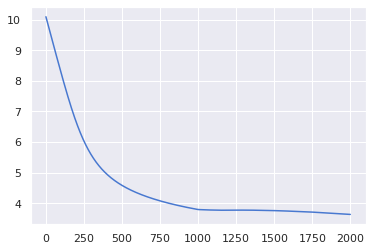

Number agreement, 1 latent variable


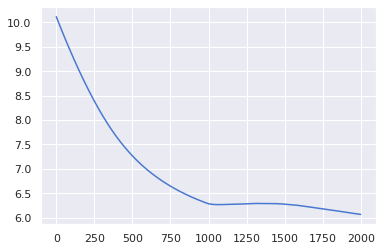

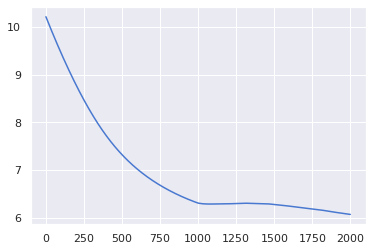

Gender agreement, 1 latent variable


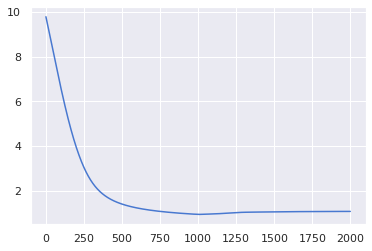

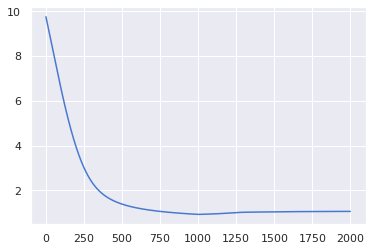

Person agreement, 1 latent variable


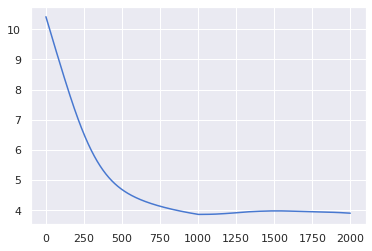

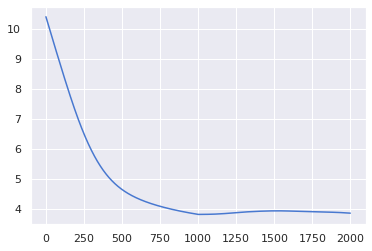

Number agreement, 1 latent variable


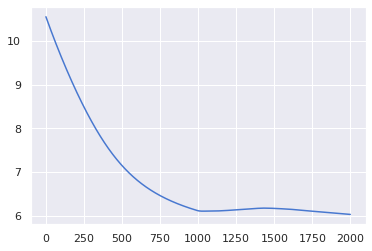

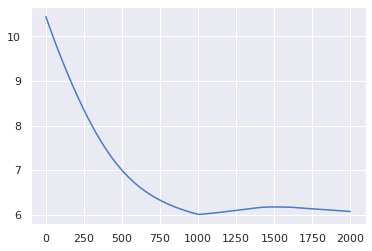

Gender agreement, 1 latent variable


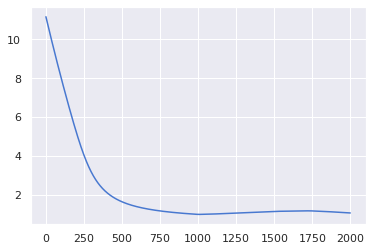

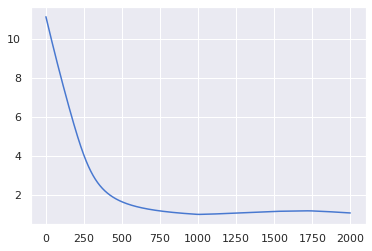

Person agreement, 1 latent variable


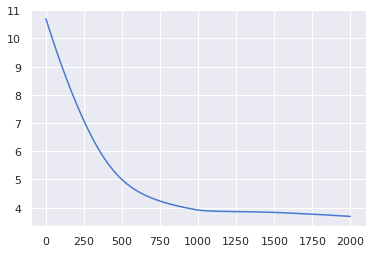

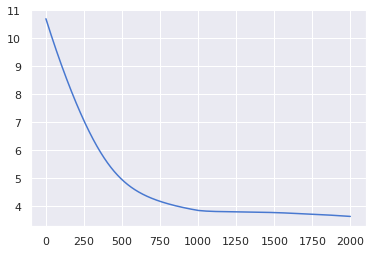

Number agreement, 1 latent variable


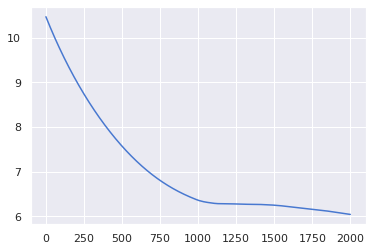

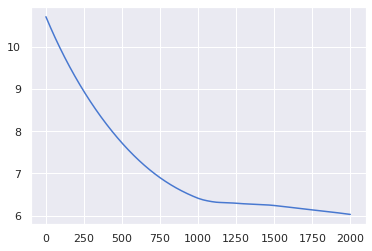

Gender agreement, 1 latent variable


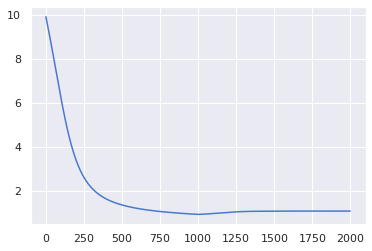

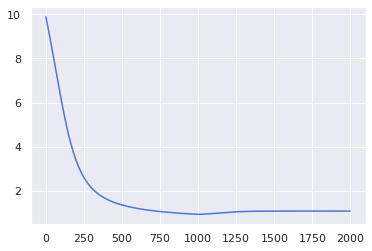

Person agreement, 1 latent variable


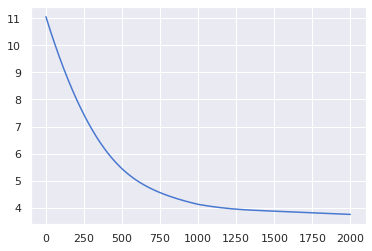

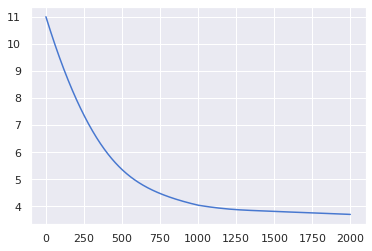

Number agreement, 1 latent variable


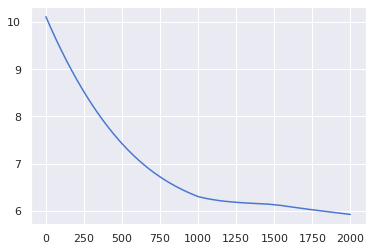

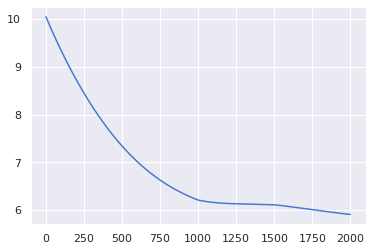

Gender agreement, 1 latent variable


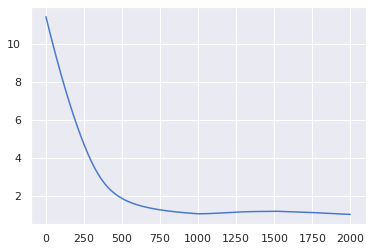

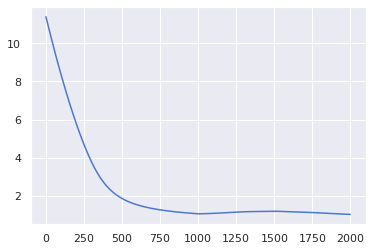

Person agreement, 1 latent variable


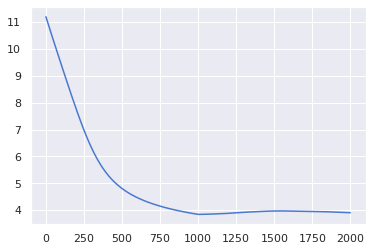

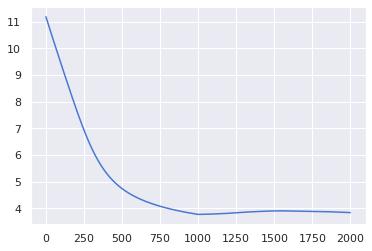

Number agreement, 1 latent variable


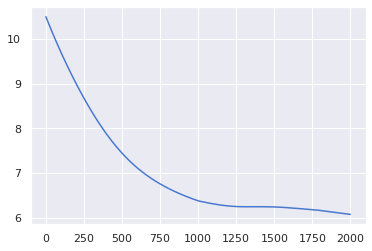

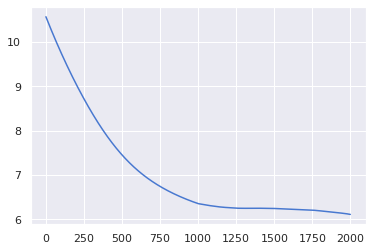

Gender agreement, 1 latent variable


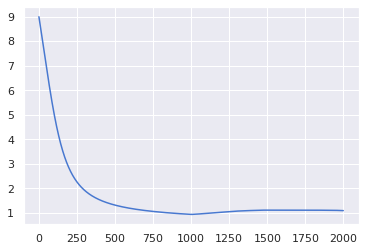

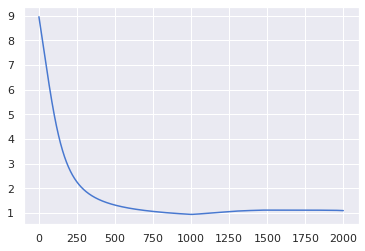

Person agreement, 1 latent variable


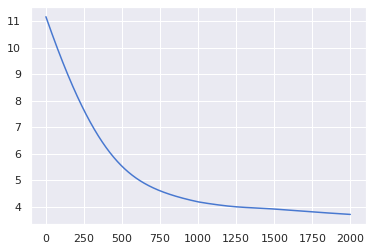

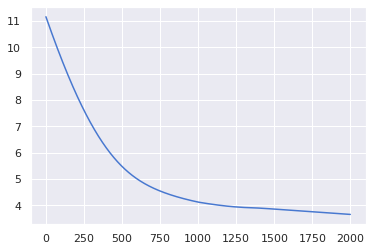

Number agreement, 1 latent variable


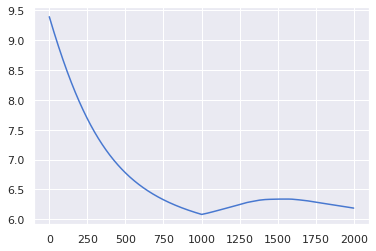

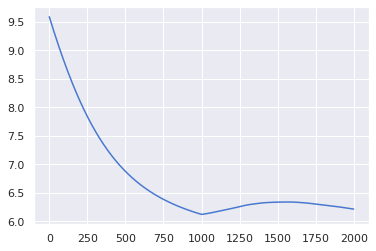

Gender agreement, 1 latent variable


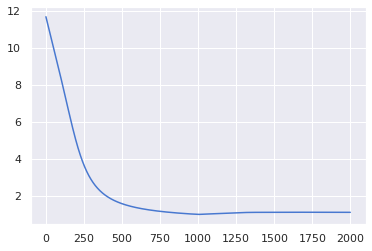

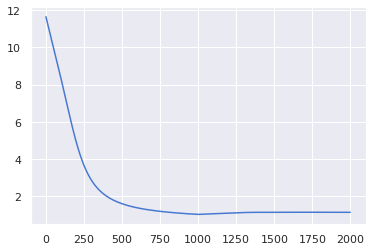

Person agreement, 1 latent variable


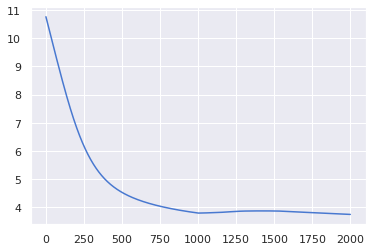

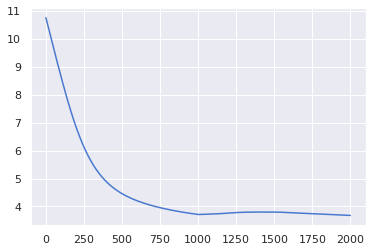

Number agreement, 1 latent variable


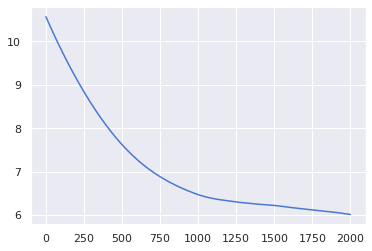

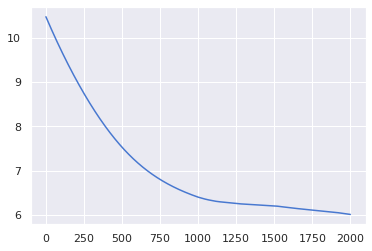

Gender agreement, 1 latent variable


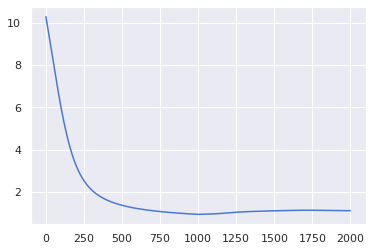

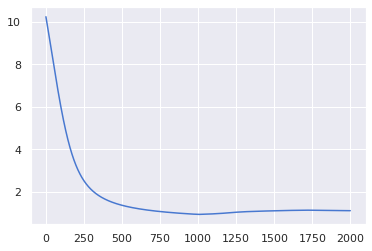

Person agreement, 1 latent variable


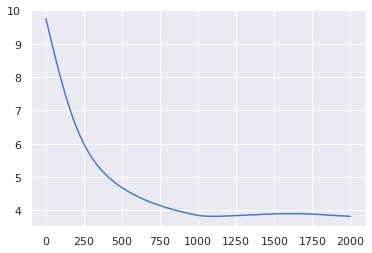

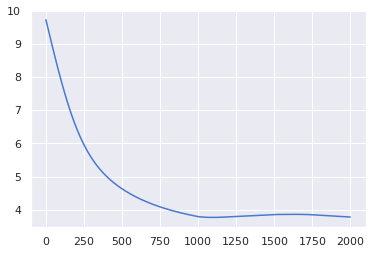

Number agreement, 1 latent variable


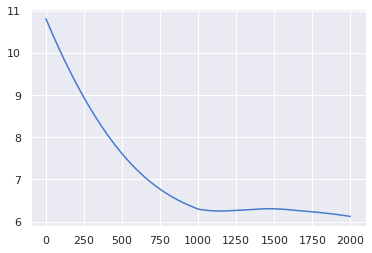

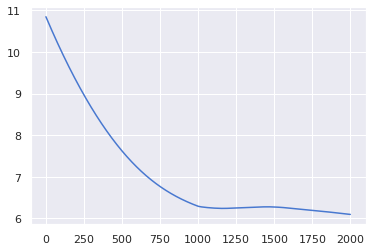

Gender agreement, 1 latent variable


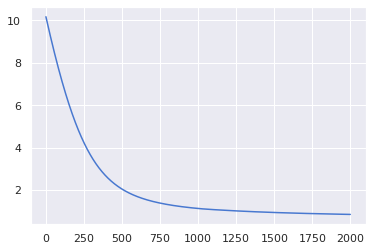

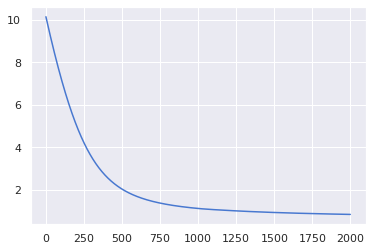

Person agreement, 1 latent variable


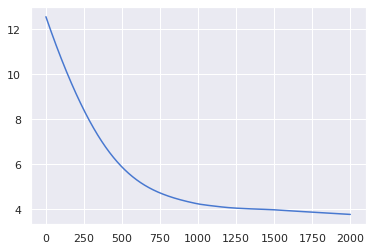

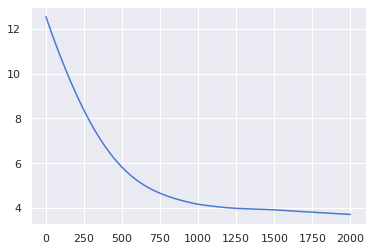

In [20]:
# No. latent variables = 1
rule_number_1 = {}
rule_gender_1 = {}
rule_person_1 = {}
    
# Rerun model 20 times to achieve the most frequently occurring rules
for epoch in range(20):
    
    # Number agreement
    print('Number agreement, 1 latent variable')
    sbn_number_1 = fun.AdaSBN(n_latent = 1 , n_observed_binary = 1, n_observed_discrete = len_discrete_number)
    sbn_number_1.to(device)
    binary_weight_number_1, binary_bias_number_1, discrete_weight_number_1, discrete_bias_number_1, liklihood_number_1 = fun.training_process (reg_weight = 0.002, proximal = True,binary_data = number_agreement, discrete_data = discrete_number, sbn_adaptive = sbn_number_1, valid_binary_data = valid_number_agreement, valid_discrete_data = valid_discrete_number)
    pd_binary_number_1, pd_discrete_full_number_1, pd_discrete_sparsity_number_1, pd_z_number_1 = fun.visual_result_new(binary_weight_number_1, binary_bias_number_1, discrete_weight_number_1, discrete_bias_number_1, 1, ['Number_agreement'], re_classes_number, sbn_number_1)
    #print(pd_binary_number_1, pd_discrete_sparsity_number_1, pd_z_number_1)
    #rule_number_1 = set(fun.possible_rules(pd_discrete_sparsity_number,pd_binary_number,1))
    for i in fun.possible_rules(pd_discrete_sparsity_number_1,pd_binary_number_1,1):
        rule_number_1[i] = rule_number_1.get(i,0) + 1



    # Gender agreement
    print('Gender agreement, 1 latent variable')
    sbn_gender_1 = fun.AdaSBN(n_latent = 1, n_observed_binary = 1, n_observed_discrete = len_discrete_gender)
    sbn_gender_1.to(device)
    binary_weight_gender_1, binary_bias_gender_1, discrete_weight_gender_1, discrete_bias_gender_1, liklihood_gender_1 = fun.training_process (reg_weight = 0.003, proximal = True,binary_data = gender_agreement, discrete_data = discrete_gender, sbn_adaptive = sbn_gender_1, valid_binary_data = valid_gender_agreement, valid_discrete_data = valid_discrete_gender)
    pd_binary_gender_1, pd_discrete_full_gender_1, pd_discrete_sparsity_gender_1, pd_z_gender_1 = fun.visual_result_new(binary_weight_gender_1, binary_bias_gender_1, discrete_weight_gender_1, discrete_bias_gender_1, 1, ['Gender_agreement'], re_classes_gender, sbn_gender_1)
    for i in fun.possible_rules(pd_discrete_sparsity_gender_1,pd_binary_gender_1,1):
        rule_gender_1[i] = rule_gender_1.get(i,0) + 1
    #print(pd_binary_gender_1, pd_discrete_sparsity_gender_1, pd_z_gender_1)
    #rule_gender_1 = set(fun.possible_rules(pd_discrete_sparsity_gender,pd_binary_gender,1))
    #print('possible_rules:', rule_gender_1)

    # Person agreement
    print('Person agreement, 1 latent variable')
    sbn_person_1 = fun.AdaSBN(n_latent = 1 , n_observed_binary = 1, n_observed_discrete = len_discrete_person)
    sbn_person_1.to(device)
    binary_weight_person_1, binary_bias_person_1, discrete_weight_person_1, discrete_bias_person_1, liklihood_person_1 = fun.training_process (reg_weight = 0.002, proximal = True,binary_data = person_agreement, discrete_data = discrete_person, sbn_adaptive = sbn_person_1, valid_binary_data = valid_person_agreement, valid_discrete_data = valid_discrete_person)
    pd_binary_person_1, pd_discrete_full_person_1, pd_discrete_sparsity_person_1, pd_z_person_1 = fun.visual_result_new(binary_weight_person_1, binary_bias_person_1, discrete_weight_person_1, discrete_bias_person_1, 1, ['Person_agreement'], re_classes_person, sbn_person_1)
    for i in fun.possible_rules(pd_discrete_sparsity_person_1,pd_binary_person_1,1):
        rule_person_1[i] = rule_person_1.get(i,0) + 1
    #print(pd_binary_person_1, pd_discrete_sparsity_person_1, pd_z_person_1)
    #rule_person_1 = set(fun.possible_rules(pd_discrete_sparsity_person,pd_binary_person,1))
    #print('possible_rules:', rule_person_1)

    #print('All agreement')
    # All the features exists same time
    #sbn_all = fun.AdaSBN(n_latent = 1, n_observed_binary = 1, n_observed_discrete = len_discrete_all)
    #sbn_all.to(device)
    #binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all,  liklihood_all = fun.training_process (reg_weight = 0.002, proximal = True,binary_data = all_agreement, discrete_data = discrete_all, sbn_adaptive = sbn_all, valid_binary_data = valid_all_agreement, valid_discrete_data = valid_discrete_all)
    #pd_binary_all, pd_discrete_full_all, pd_discrete_sparsity_all, pd_z_all = fun.visual_result_new(binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all, 1, ['All_agreement'], re_classes_all, sbn_all)
    #print(pd_binary_all, pd_discrete_sparsity_all, pd_z_all)
    #rule_all_1 = set(fun.possible_rules(pd_discrete_sparsity_all,pd_binary_all,1))
    #print('possible_rules:', rule_all_1)

Number agreement, 3 latent variable


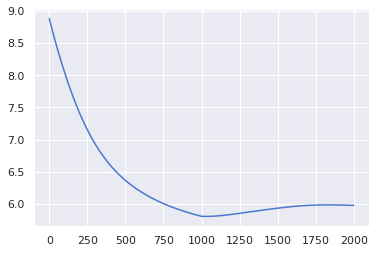

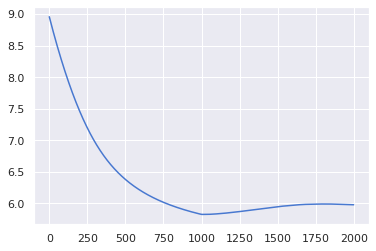

Gender agreement, 3 latent variable


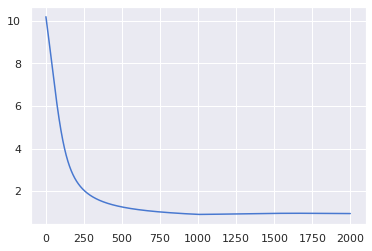

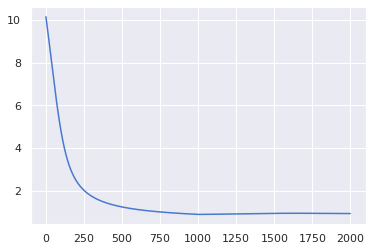

Person agreement, 3 latent variable


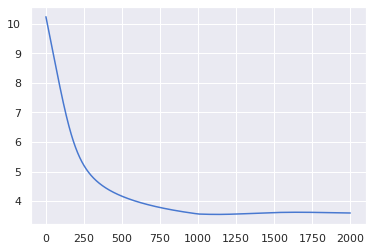

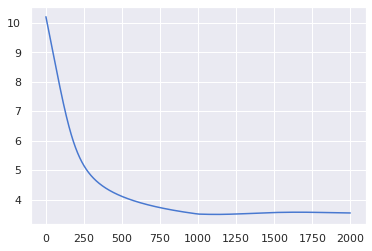

Number agreement, 3 latent variable


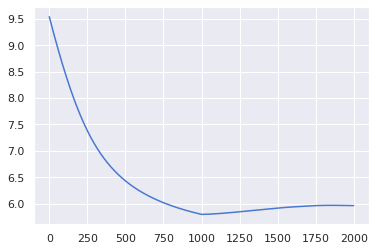

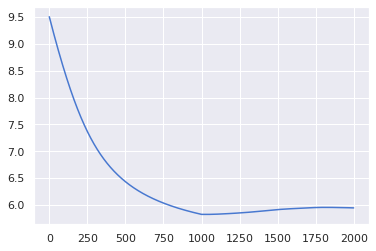

Gender agreement, 3 latent variable


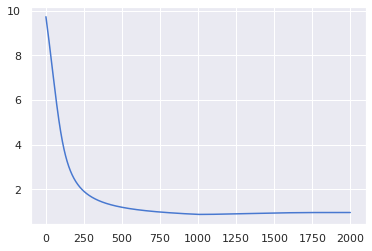

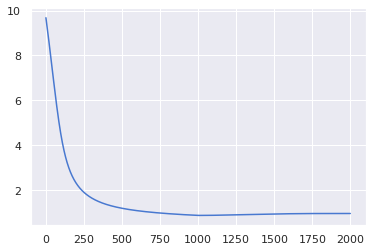

Person agreement, 3 latent variable


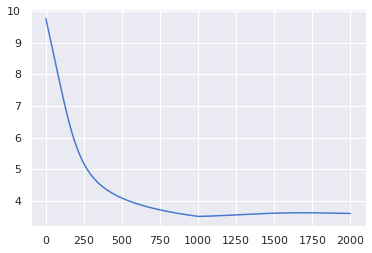

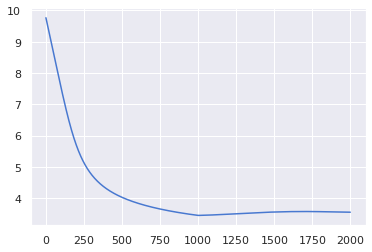

Number agreement, 3 latent variable


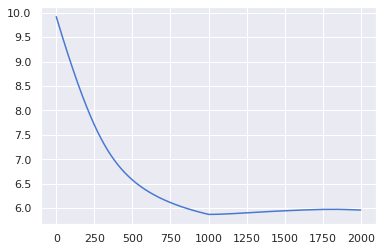

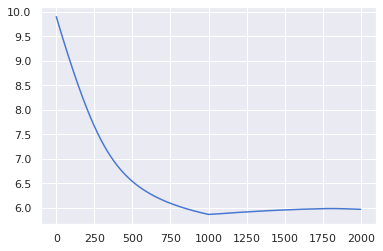

Gender agreement, 3 latent variable


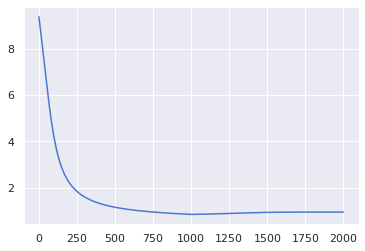

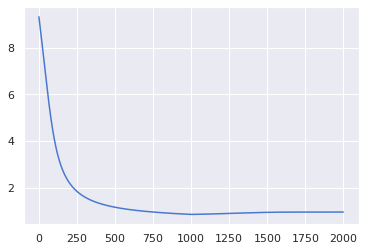

Person agreement, 3 latent variable


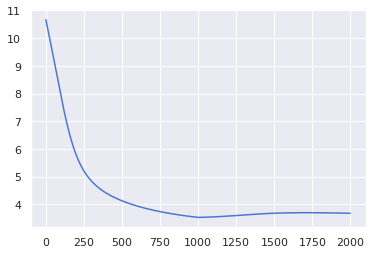

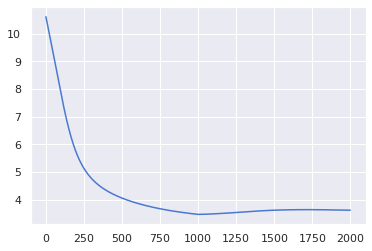

Number agreement, 3 latent variable


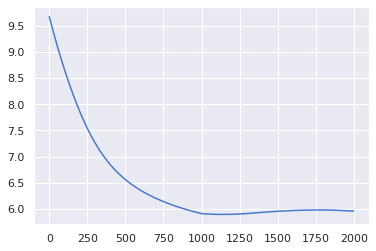

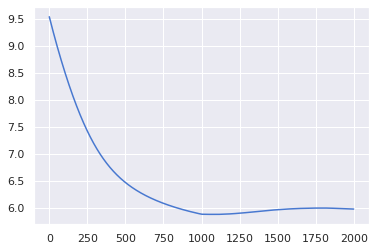

Gender agreement, 3 latent variable


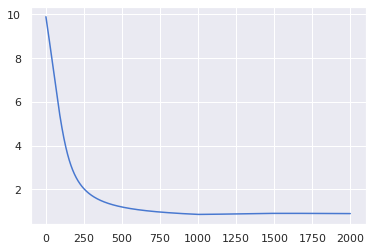

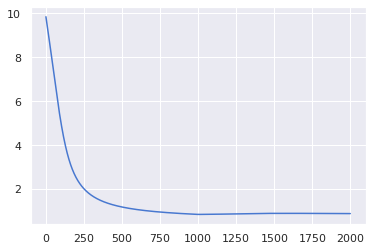

Person agreement, 3 latent variable


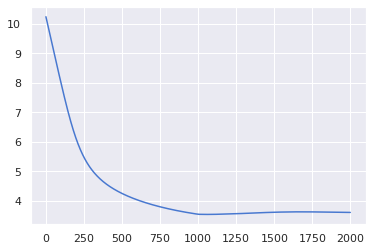

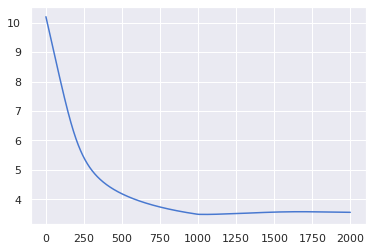

Number agreement, 3 latent variable


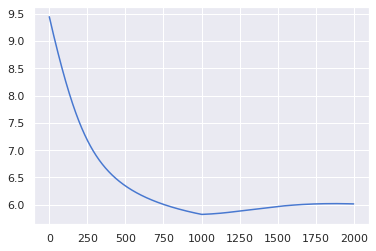

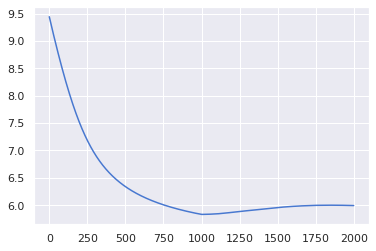

Gender agreement, 3 latent variable


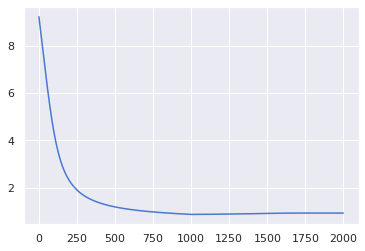

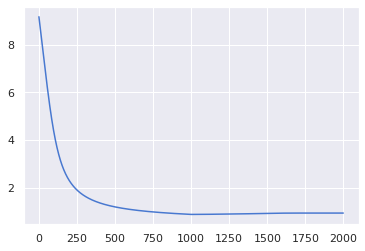

Person agreement, 3 latent variable


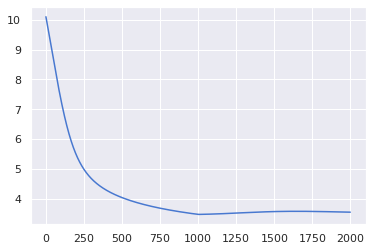

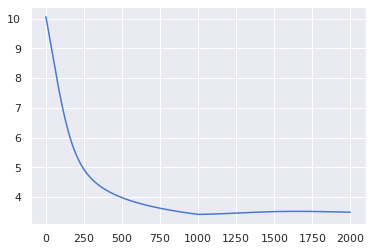

Number agreement, 3 latent variable


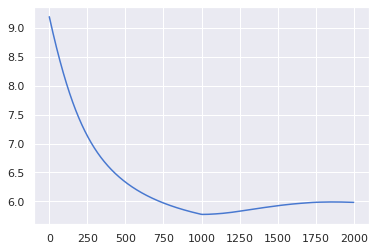

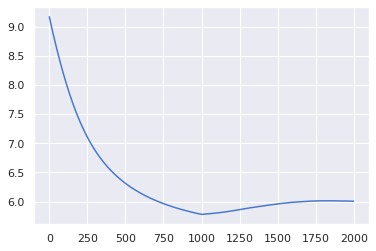

Gender agreement, 3 latent variable


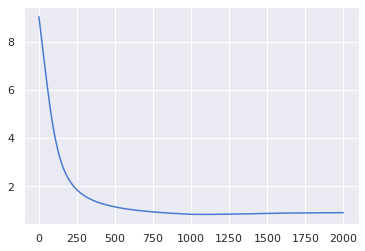

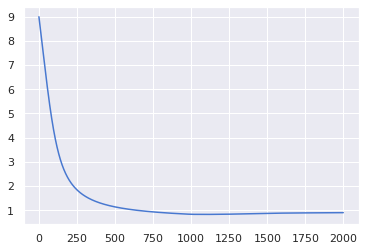

Person agreement, 3 latent variable


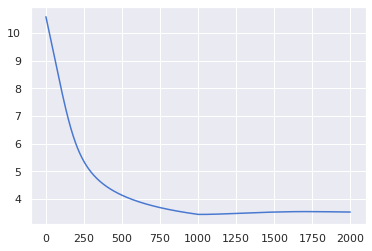

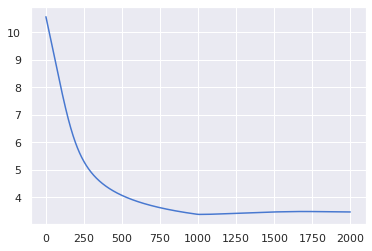

Number agreement, 3 latent variable


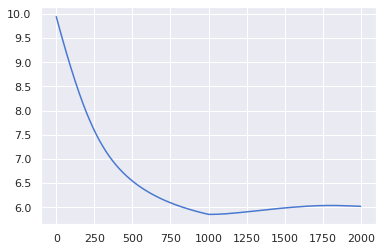

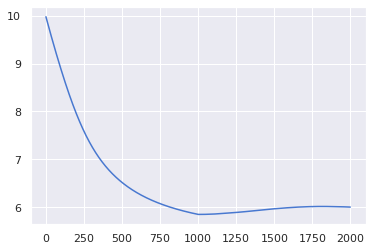

Gender agreement, 3 latent variable


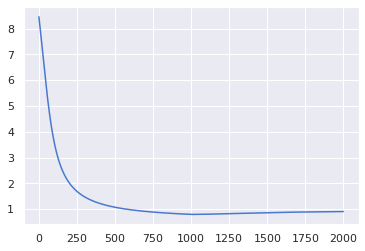

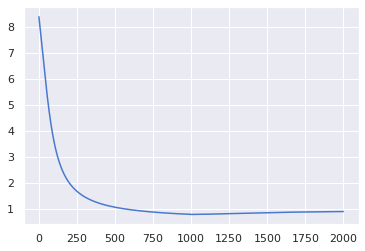

Person agreement, 3 latent variable


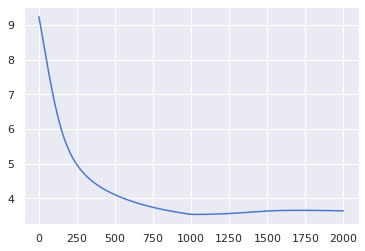

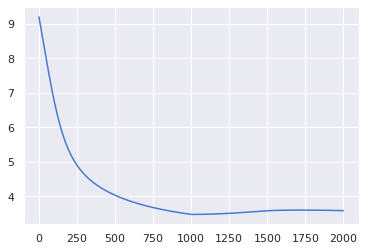

Number agreement, 3 latent variable


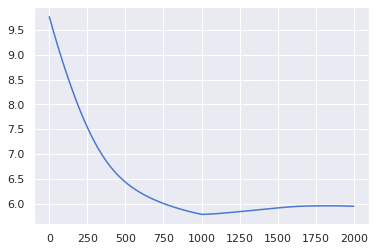

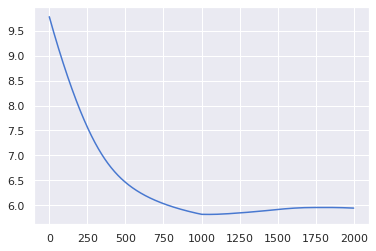

Gender agreement, 3 latent variable


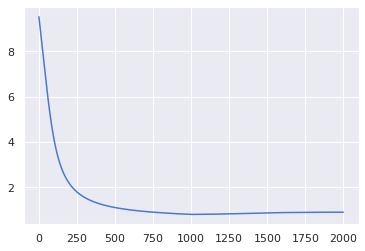

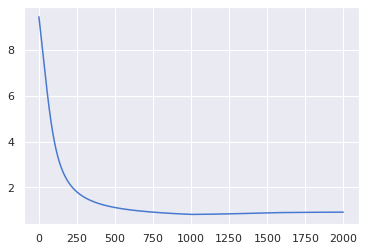

Person agreement, 3 latent variable


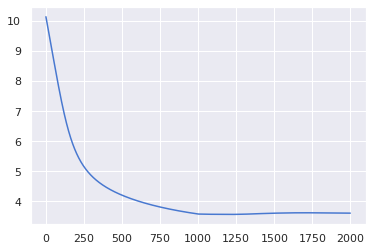

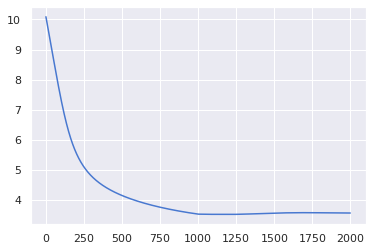

Number agreement, 3 latent variable


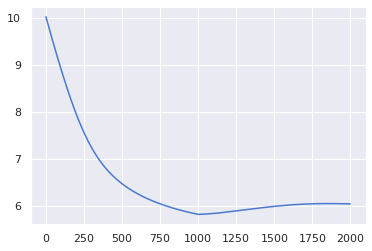

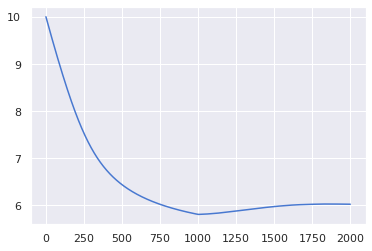

Gender agreement, 3 latent variable


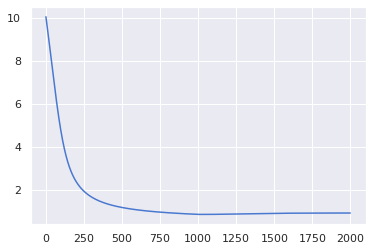

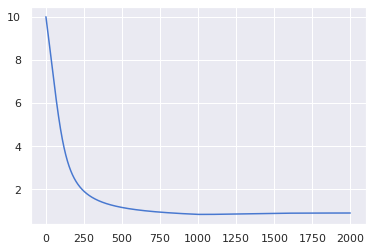

Person agreement, 3 latent variable


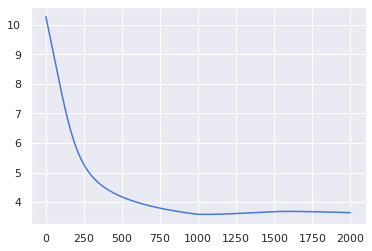

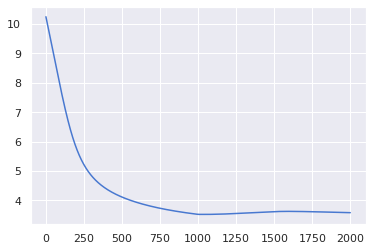

Number agreement, 3 latent variable


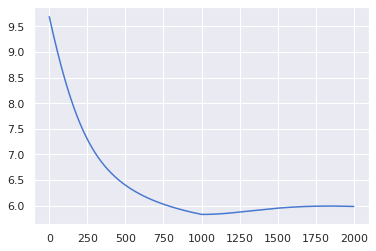

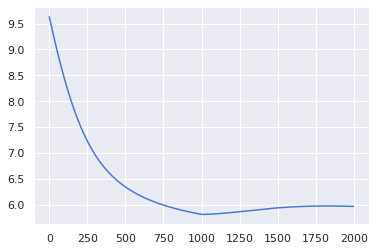

Gender agreement, 3 latent variable


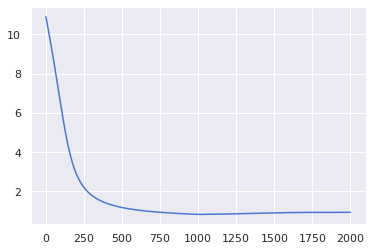

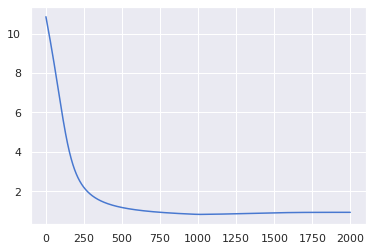

Person agreement, 3 latent variable


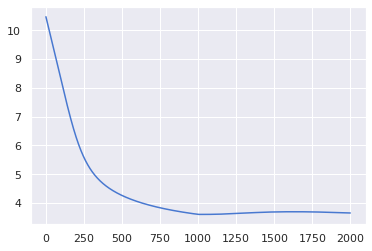

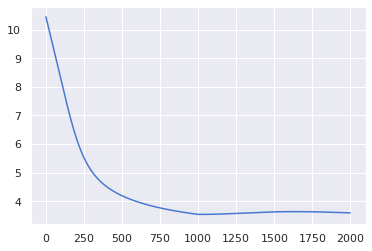

Number agreement, 3 latent variable


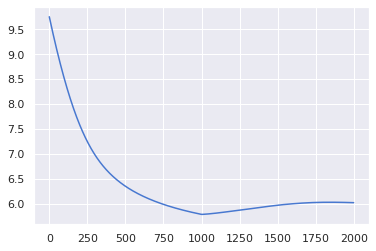

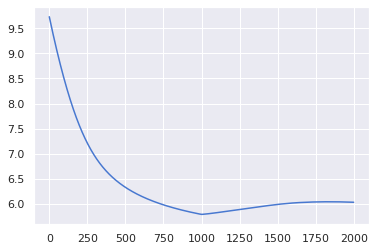

Gender agreement, 3 latent variable


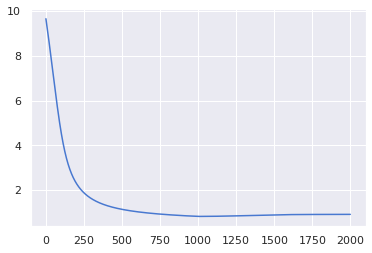

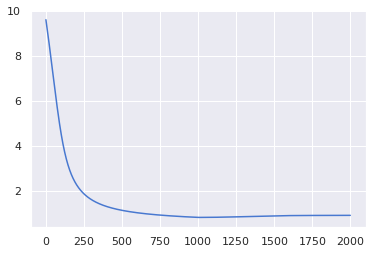

Person agreement, 3 latent variable


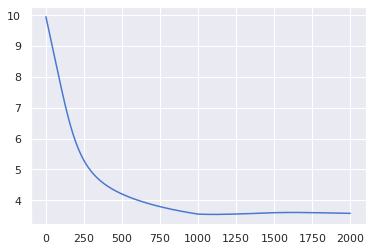

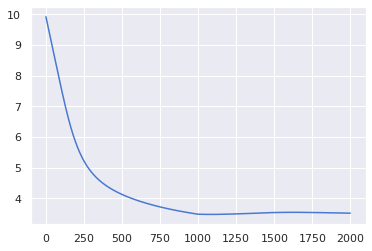

Number agreement, 3 latent variable


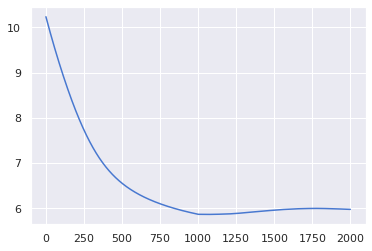

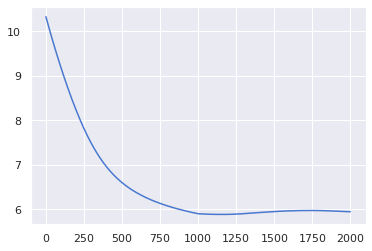

Gender agreement, 3 latent variable


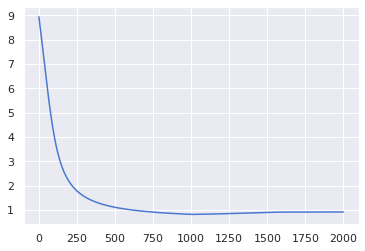

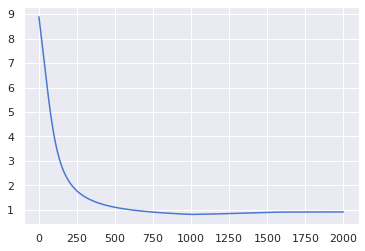

Person agreement, 3 latent variable


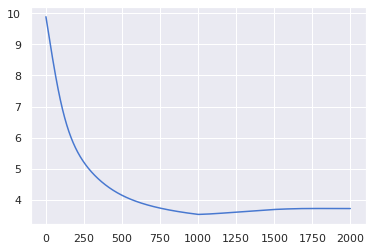

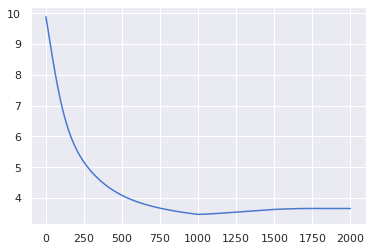

Number agreement, 3 latent variable


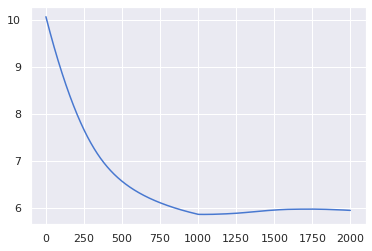

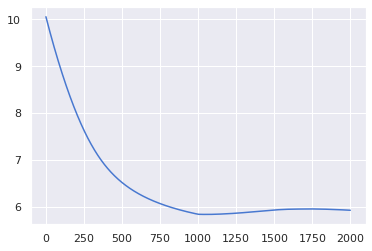

Gender agreement, 3 latent variable


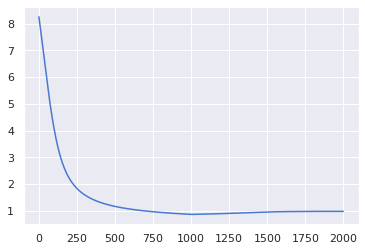

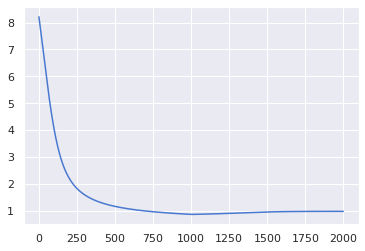

Person agreement, 3 latent variable


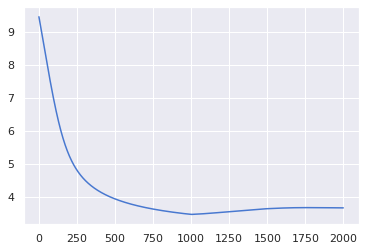

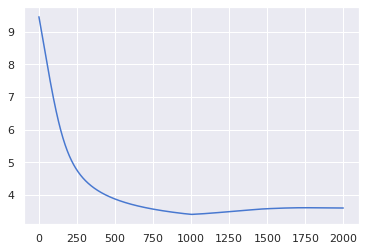

Number agreement, 3 latent variable


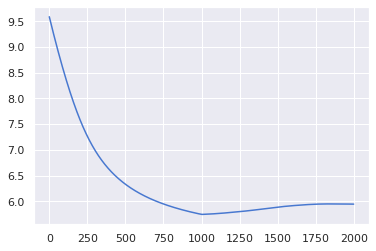

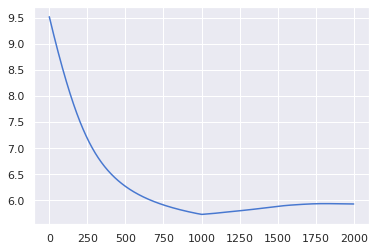

Gender agreement, 3 latent variable


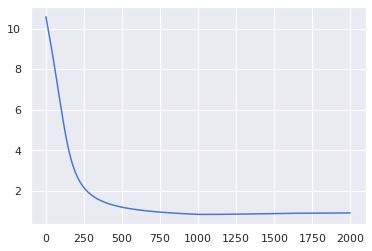

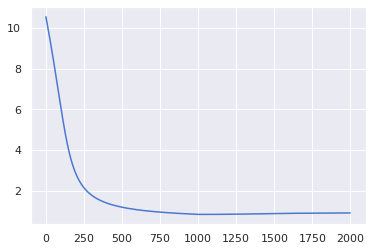

Person agreement, 3 latent variable


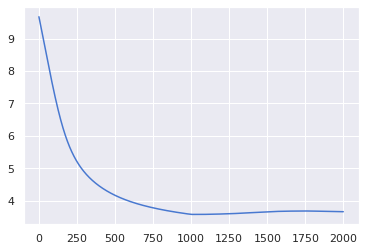

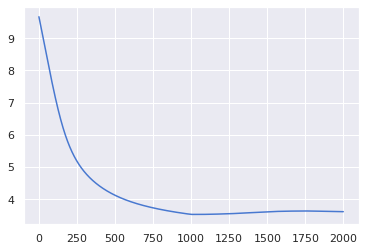

Number agreement, 3 latent variable


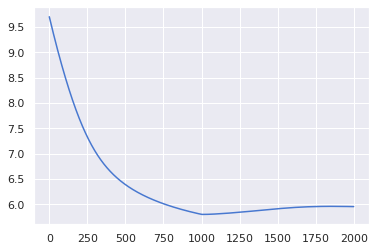

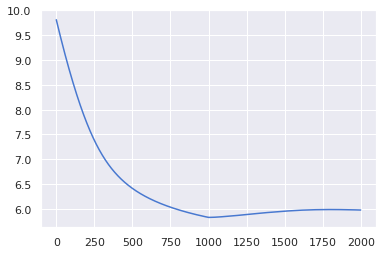

Gender agreement, 3 latent variable


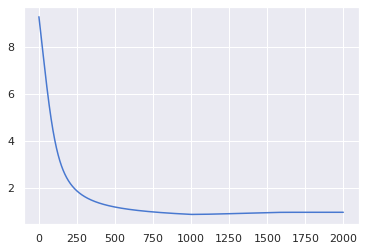

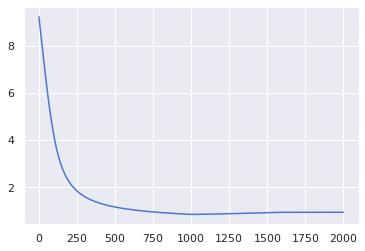

Person agreement, 3 latent variable


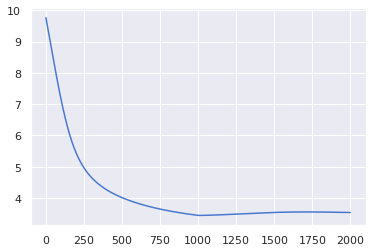

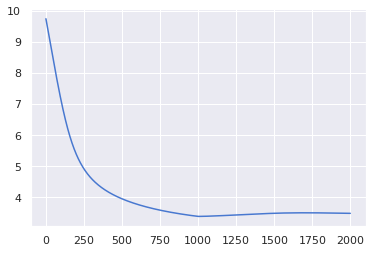

Number agreement, 3 latent variable


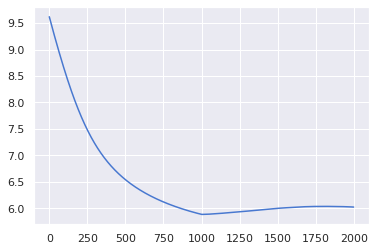

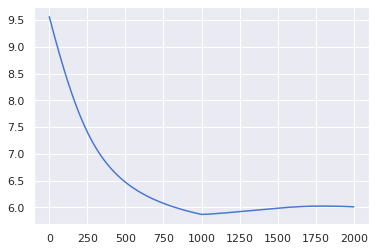

Gender agreement, 3 latent variable


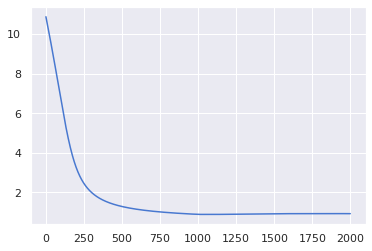

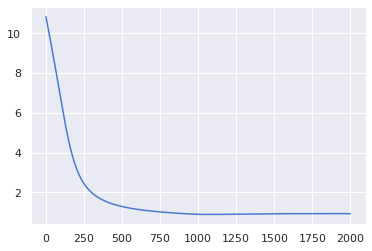

Person agreement, 3 latent variable


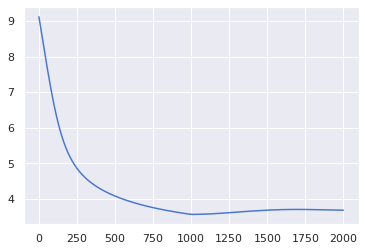

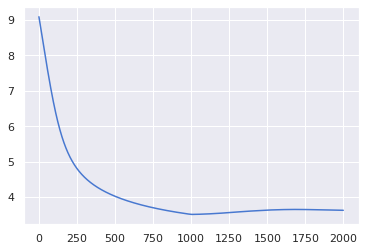

Number agreement, 3 latent variable


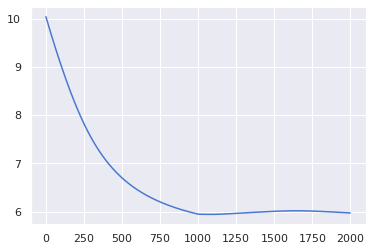

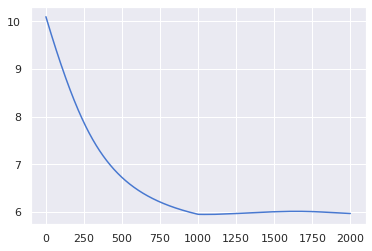

Gender agreement, 3 latent variable


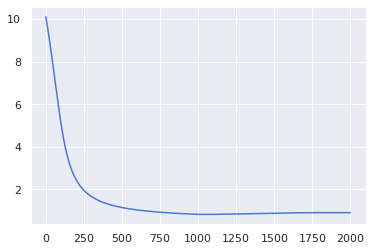

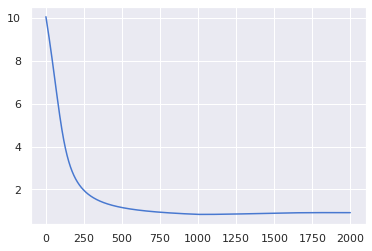

Person agreement, 3 latent variable


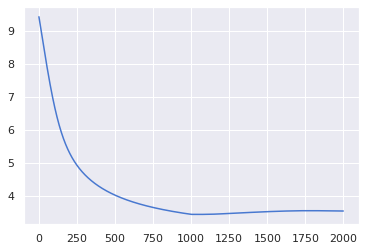

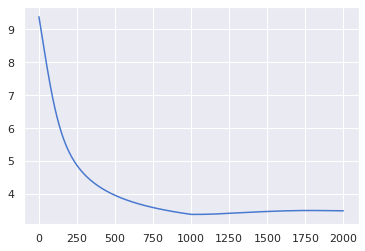

Number agreement, 3 latent variable


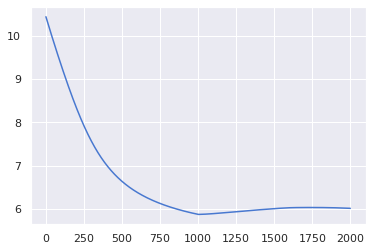

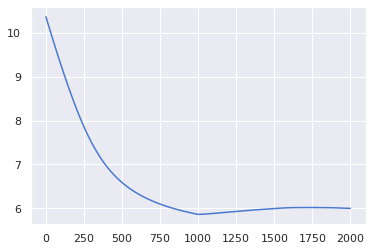

Gender agreement, 3 latent variable


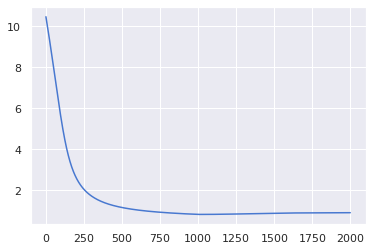

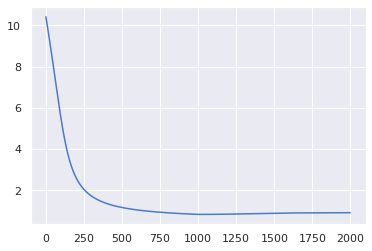

Person agreement, 3 latent variable


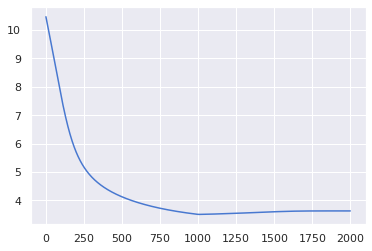

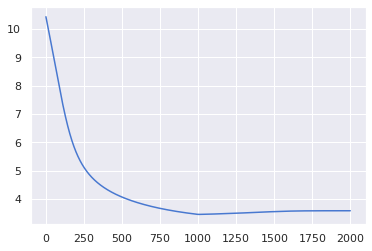

Number agreement, 3 latent variable


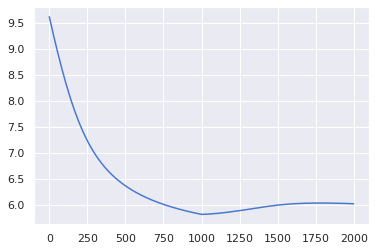

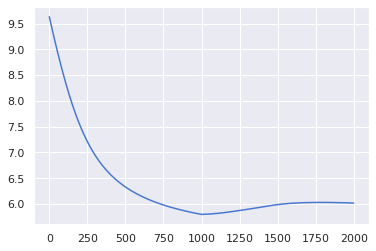

Gender agreement, 3 latent variable


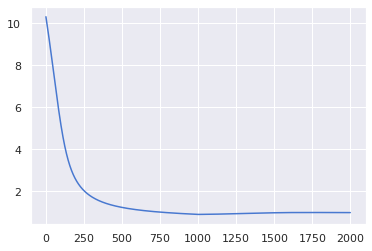

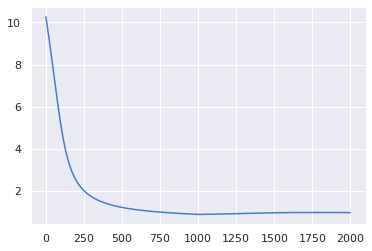

Person agreement, 3 latent variable


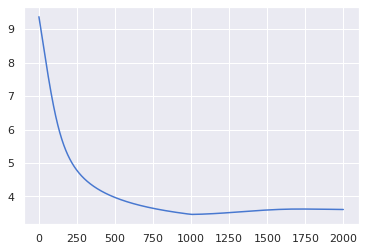

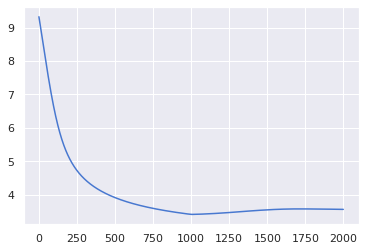

Number agreement, 3 latent variable


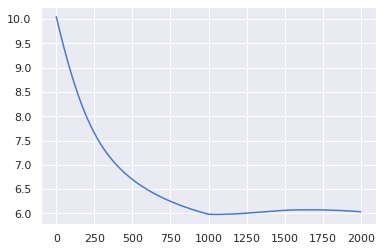

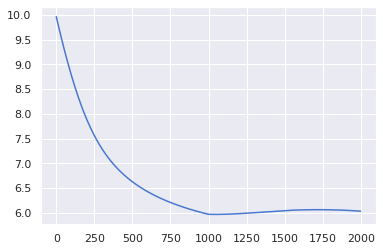

Gender agreement, 3 latent variable


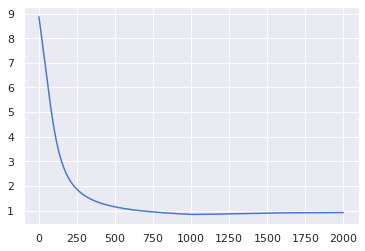

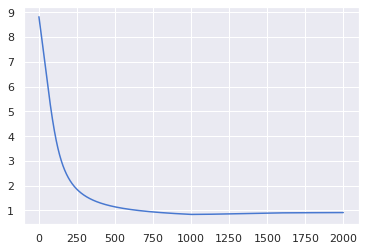

Person agreement, 3 latent variable


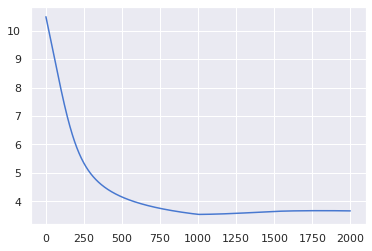

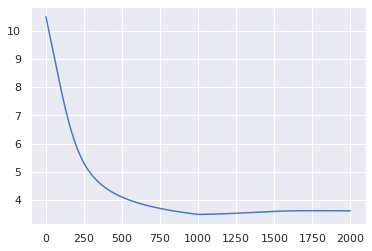

In [21]:
# No. latent variables = 3
rule_number_3 = {}
rule_gender_3 = {}
rule_person_3 = {}

for epoch in range(20):
    
    # Number agreement
    print('Number agreement, 3 latent variable')
    sbn_number_3 = fun.AdaSBN(n_latent = 3 , n_observed_binary = 1, n_observed_discrete = len_discrete_number)
    sbn_number_3.to(device)
    binary_weight_number_3, binary_bias_number_3, discrete_weight_number_3, discrete_bias_number_3, liklihood_number_3 = fun.training_process (reg_weight = 0.0008, proximal = True,binary_data = number_agreement, discrete_data = discrete_number, sbn_adaptive = sbn_number_3, valid_binary_data = valid_number_agreement, valid_discrete_data = valid_discrete_number)
    pd_binary_number_3, pd_discrete_full_number_3, pd_discrete_sparsity_number_3, pd_z_number_3 = fun.visual_result_new(binary_weight_number_3, binary_bias_number_3, discrete_weight_number_3, discrete_bias_number_3, 3, ['Number_agreement'], re_classes_number, sbn_number_3)
    #print(pd_binary_number_3, pd_discrete_sparsity_number_3, pd_z_number_3)
    for i in fun.possible_rules(pd_discrete_sparsity_number_3,pd_binary_number_3,3):
        rule_number_3[i] = rule_number_3.get(i,0) + 1



    # Gender agreement
    print('Gender agreement, 3 latent variable')
    sbn_gender_3 = fun.AdaSBN(n_latent = 3, n_observed_binary = 1, n_observed_discrete = len_discrete_gender)
    sbn_gender_3.to(device)
    binary_weight_gender_3, binary_bias_gender_3, discrete_weight_gender_3, discrete_bias_gender_3, liklihood_gender_3 = fun.training_process (reg_weight = 0.001, proximal = True,binary_data = gender_agreement, discrete_data = discrete_gender, sbn_adaptive = sbn_gender_3, valid_binary_data = valid_gender_agreement, valid_discrete_data = valid_discrete_gender)
    pd_binary_gender_3, pd_discrete_full_gender_3, pd_discrete_sparsity_gender_3, pd_z_gender_3 = fun.visual_result_new(binary_weight_gender_3, binary_bias_gender_3, discrete_weight_gender_3, discrete_bias_gender_3, 3, ['Gender_agreement'], re_classes_gender, sbn_gender_3)
    for i in fun.possible_rules(pd_discrete_sparsity_gender_3,pd_binary_gender_3,3):
        rule_gender_3[i] = rule_gender_3.get(i,0) + 1



    # Person agreement
    print('Person agreement, 3 latent variable')
    sbn_person_3 = fun.AdaSBN(n_latent = 3 , n_observed_binary = 1, n_observed_discrete = len_discrete_person)
    sbn_person_3.to(device)
    binary_weight_person_3, binary_bias_person_3, discrete_weight_person_3, discrete_bias_person_3, liklihood_person_3 = fun.training_process (reg_weight = 0.0009, proximal = True,binary_data = person_agreement, discrete_data = discrete_person, sbn_adaptive = sbn_person_3, valid_binary_data = valid_person_agreement, valid_discrete_data = valid_discrete_person)
    pd_binary_person_3, pd_discrete_full_person_3, pd_discrete_sparsity_person_3, pd_z_person_3 = fun.visual_result_new(binary_weight_person_3, binary_bias_person_3, discrete_weight_person_3, discrete_bias_person_3, 3, ['Person_agreement'], re_classes_person, sbn_person_3)
    for i in fun.possible_rules(pd_discrete_sparsity_person_3,pd_binary_person_3,3):
        rule_person_3[i] = rule_person_3.get(i,0) + 1


    #print('All agreement')
    # All the features exists same time
    #sbn_all = fun.AdaSBN(n_latent = 3, n_observed_binary = 1, n_observed_discrete = len_discrete_all)
    #sbn_all.to(device)
    #binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all,  liklihood_all = fun.training_process (reg_weight = 0.001, proximal = True,binary_data = all_agreement, discrete_data = discrete_all, sbn_adaptive = sbn_all, valid_binary_data = valid_all_agreement, valid_discrete_data = valid_discrete_all)
    #pd_binary_all, pd_discrete_full_all, pd_discrete_sparsity_all, pd_z_all = fun.visual_result_new(binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all, 3, ['All_agreement'], re_classes_all, sbn_all)
    #print(pd_binary_all, pd_discrete_sparsity_all, pd_z_all)
    #rule_all_3 = set(fun.possible_rules(pd_discrete_sparsity_all,pd_binary_all,3))
    #print('possible_rules:', rule_all_3)

Number agreement, 5 latent variable


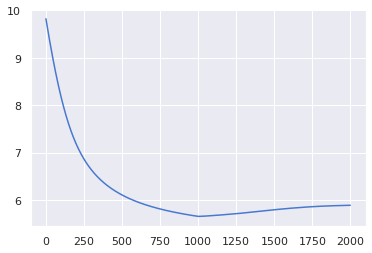

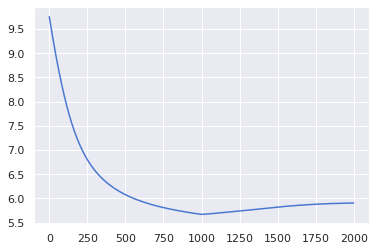

Gender agreement, 5 latent variable


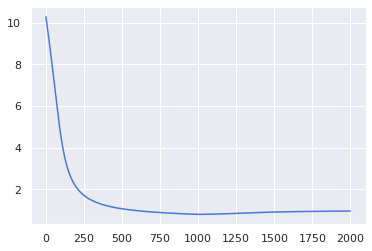

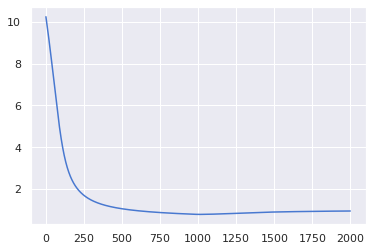

Person agreement, 5 latent variable


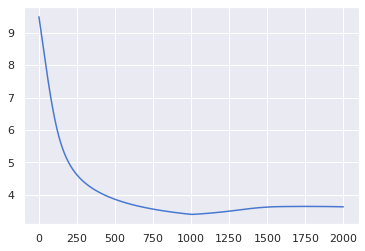

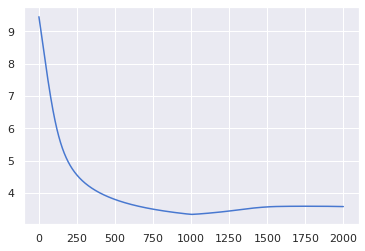

Number agreement, 5 latent variable


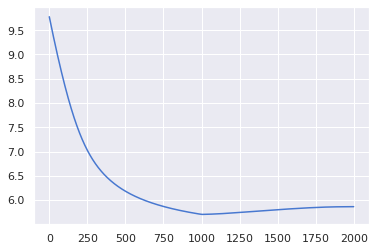

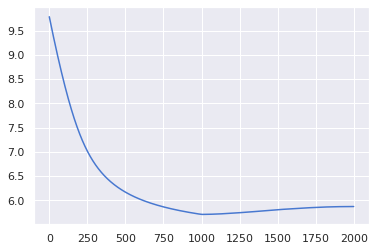

Gender agreement, 5 latent variable


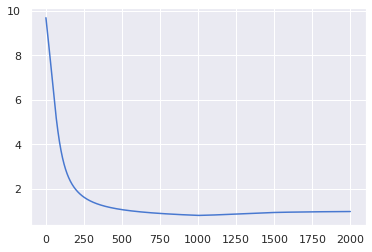

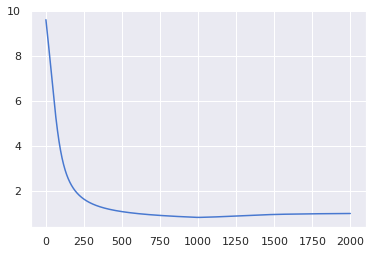

Person agreement, 5 latent variable


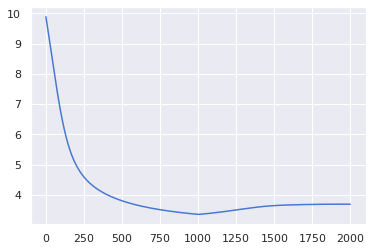

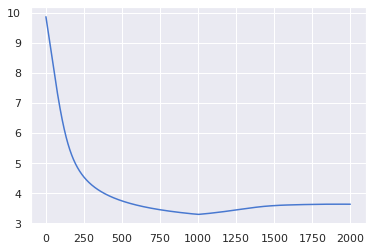

Number agreement, 5 latent variable


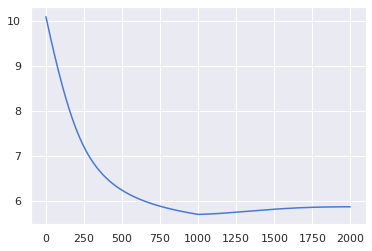

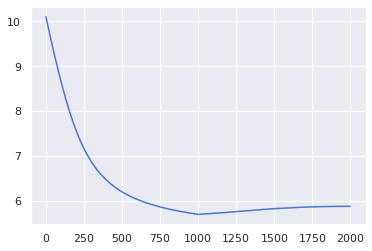

Gender agreement, 5 latent variable


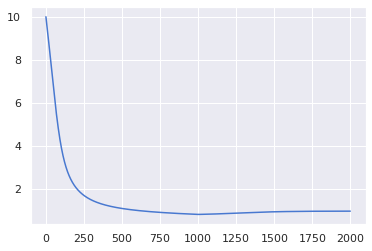

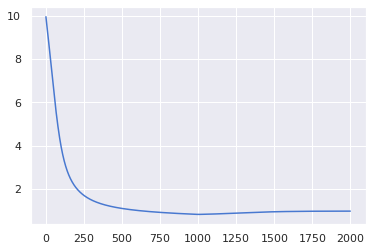

Person agreement, 5 latent variable


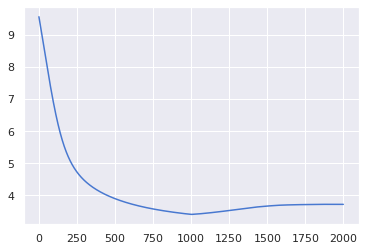

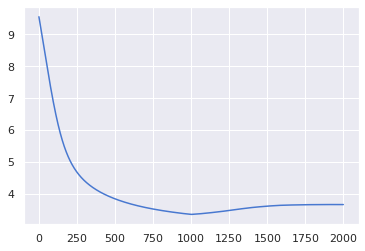

Number agreement, 5 latent variable


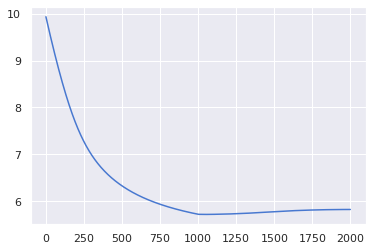

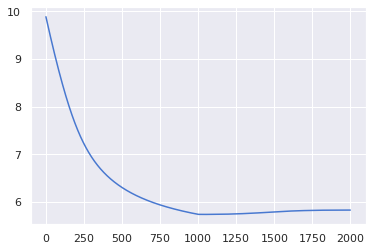

Gender agreement, 5 latent variable


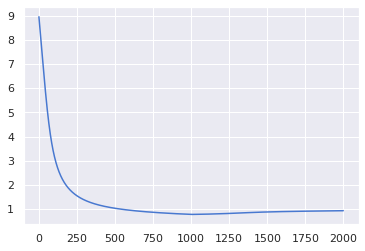

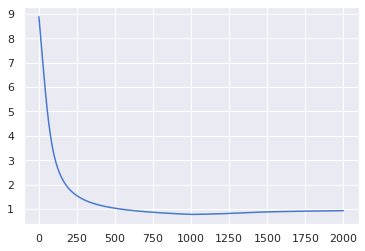

Person agreement, 5 latent variable


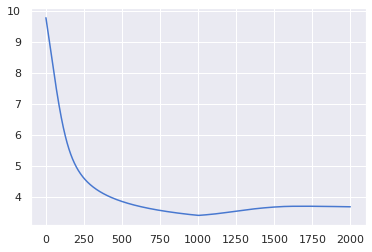

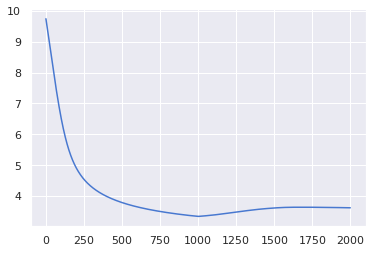

Number agreement, 5 latent variable


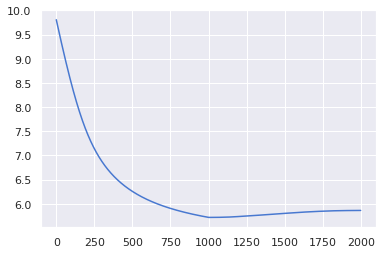

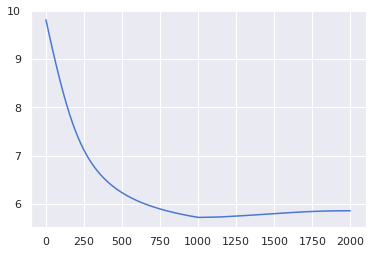

Gender agreement, 5 latent variable


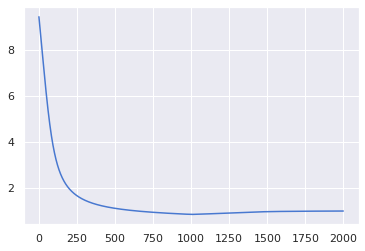

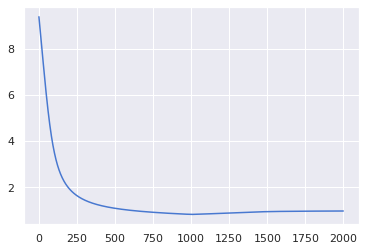

Person agreement, 5 latent variable


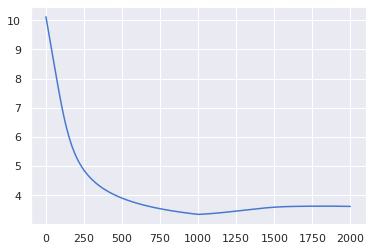

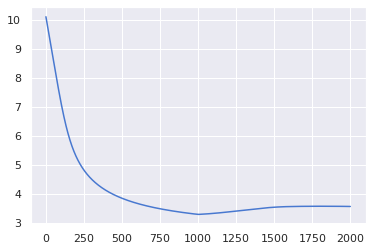

Number agreement, 5 latent variable


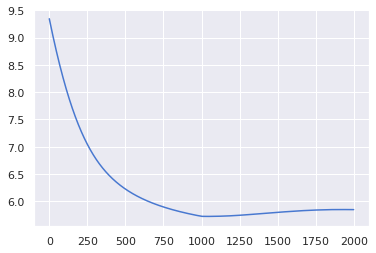

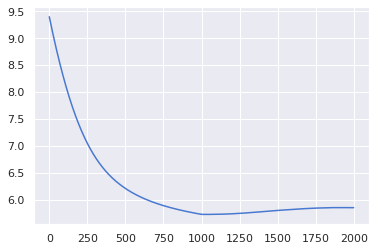

Gender agreement, 5 latent variable


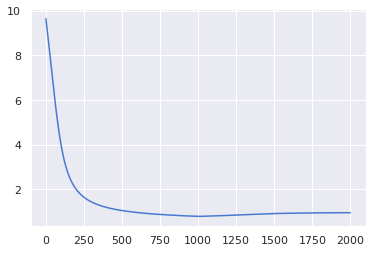

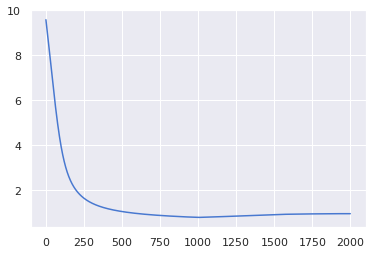

Person agreement, 5 latent variable


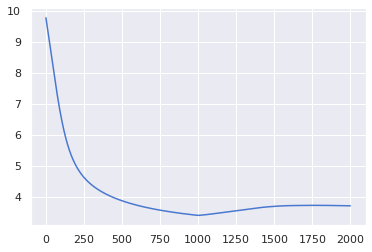

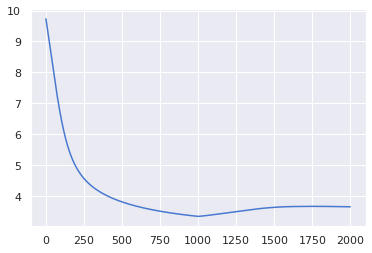

Number agreement, 5 latent variable


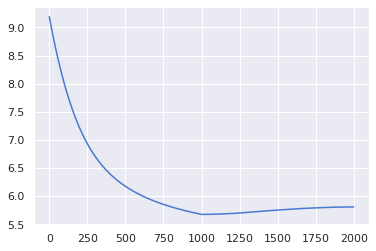

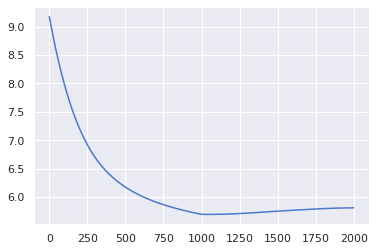

Gender agreement, 5 latent variable


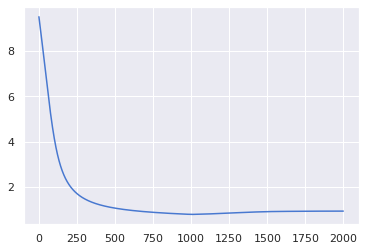

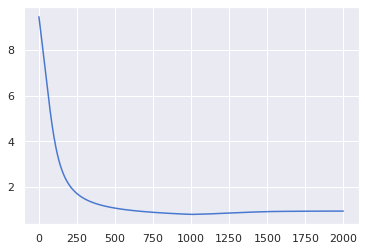

Person agreement, 5 latent variable


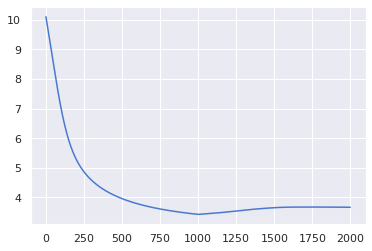

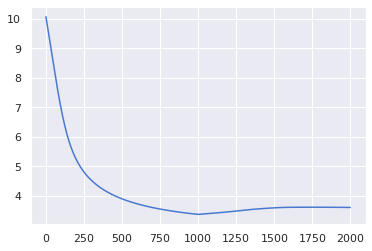

Number agreement, 5 latent variable


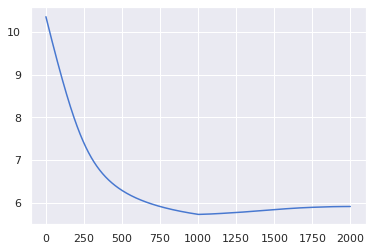

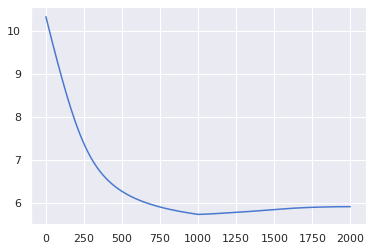

Gender agreement, 5 latent variable


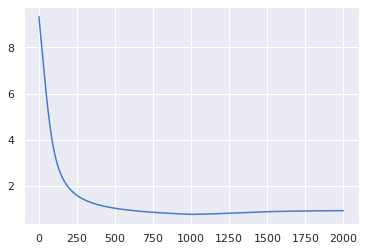

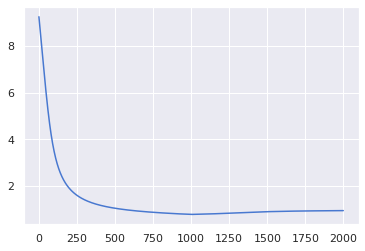

Person agreement, 5 latent variable


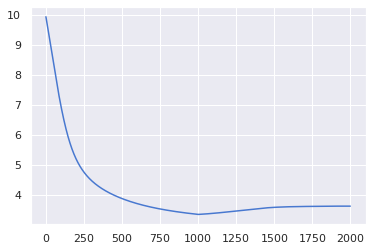

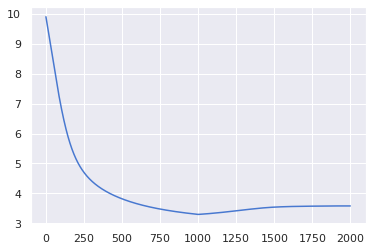

Number agreement, 5 latent variable


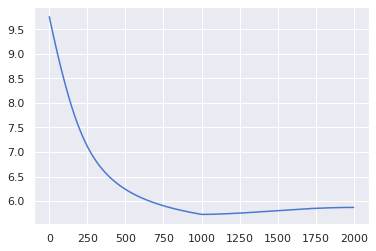

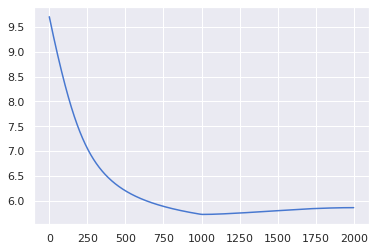

Gender agreement, 5 latent variable


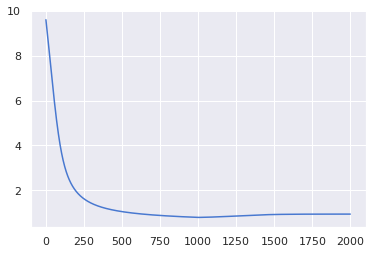

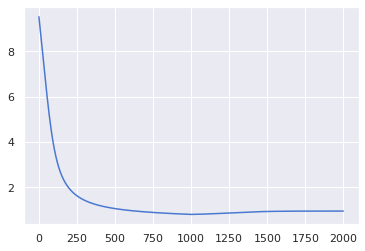

Person agreement, 5 latent variable


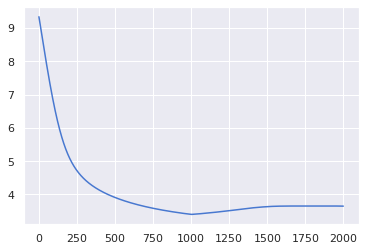

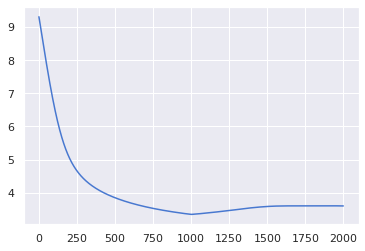

Number agreement, 5 latent variable


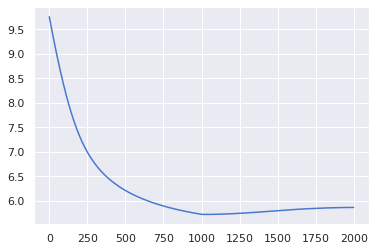

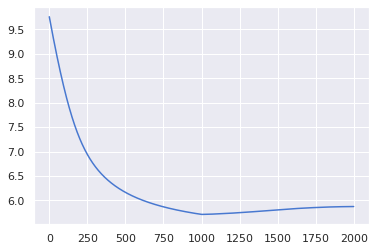

Gender agreement, 5 latent variable


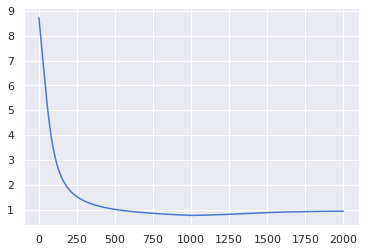

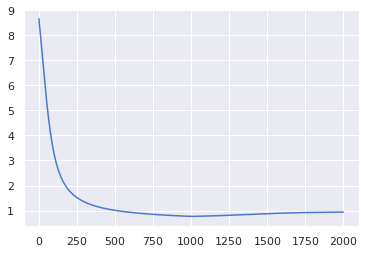

Person agreement, 5 latent variable


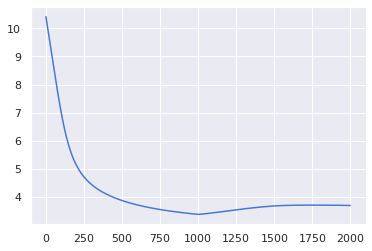

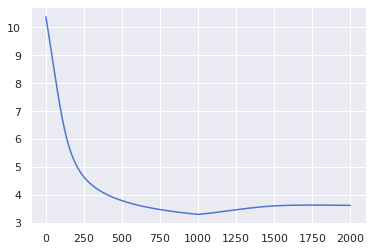

Number agreement, 5 latent variable


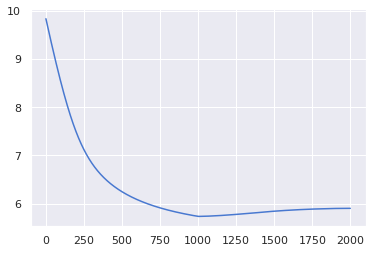

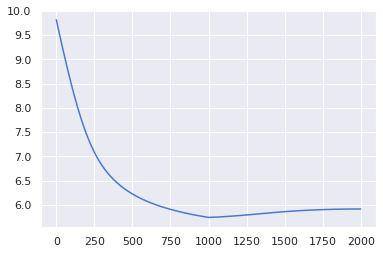

Gender agreement, 5 latent variable


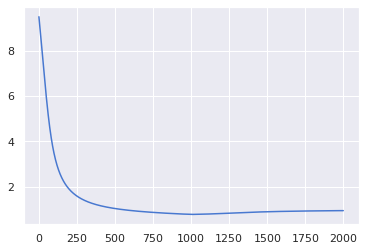

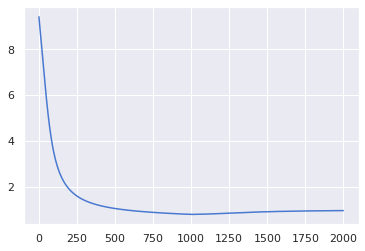

Person agreement, 5 latent variable


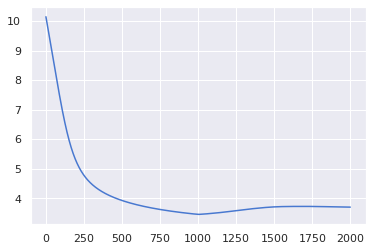

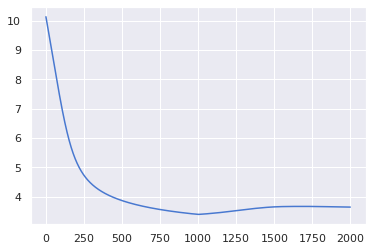

Number agreement, 5 latent variable


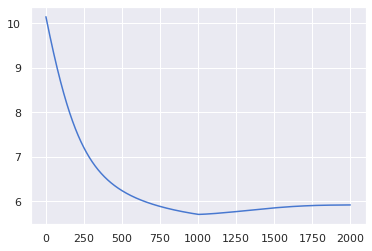

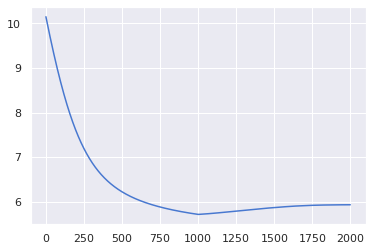

Gender agreement, 5 latent variable


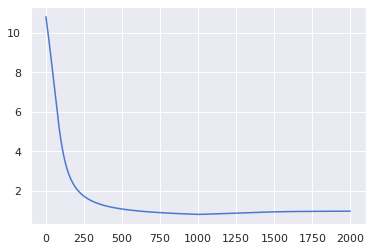

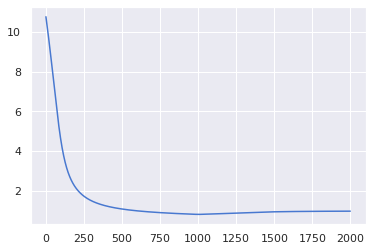

Person agreement, 5 latent variable


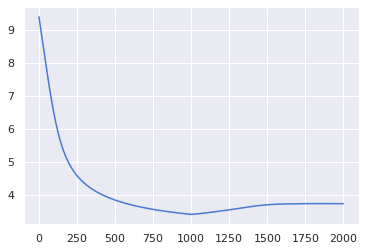

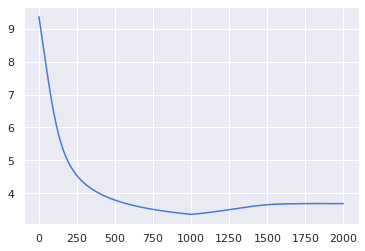

Number agreement, 5 latent variable


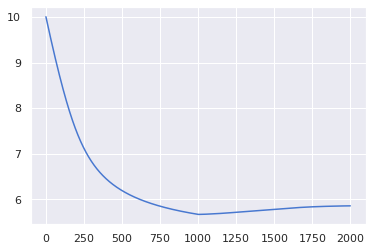

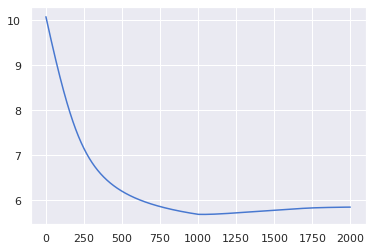

Gender agreement, 5 latent variable


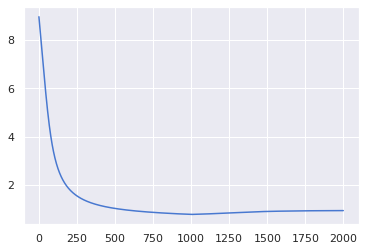

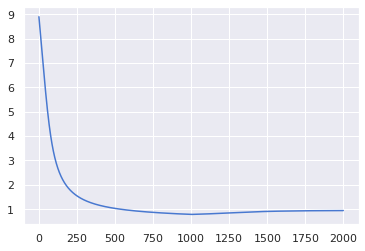

Person agreement, 5 latent variable


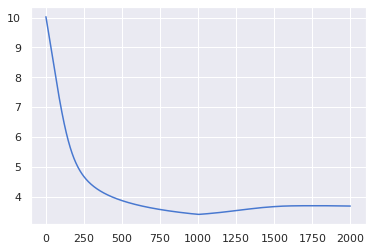

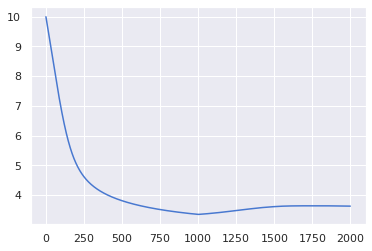

Number agreement, 5 latent variable


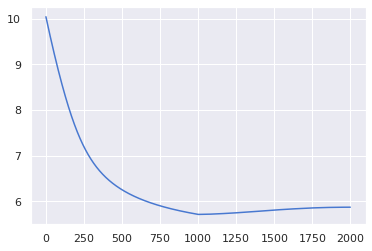

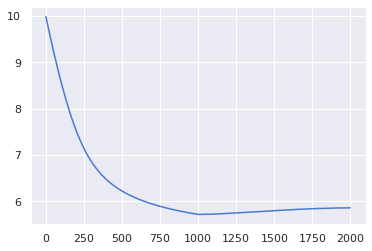

Gender agreement, 5 latent variable


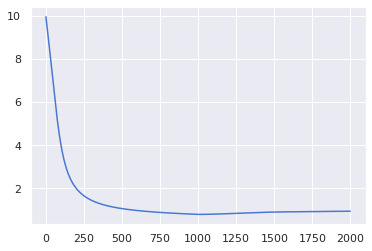

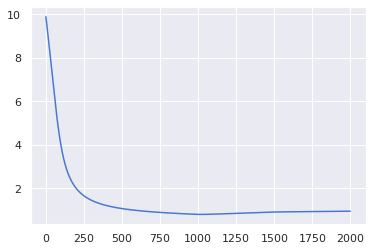

Person agreement, 5 latent variable


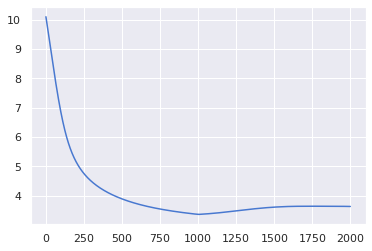

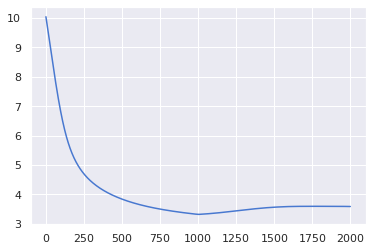

Number agreement, 5 latent variable


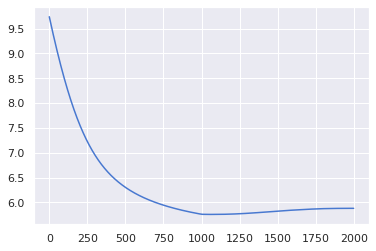

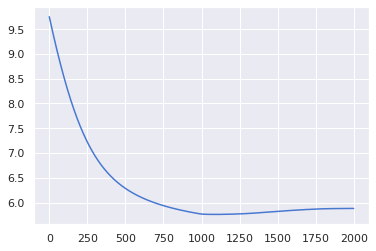

Gender agreement, 5 latent variable


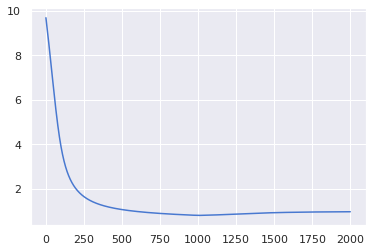

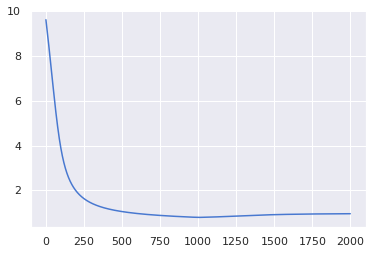

Person agreement, 5 latent variable


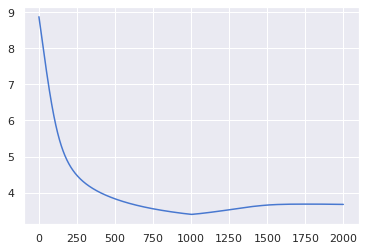

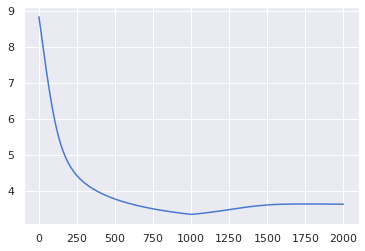

Number agreement, 5 latent variable


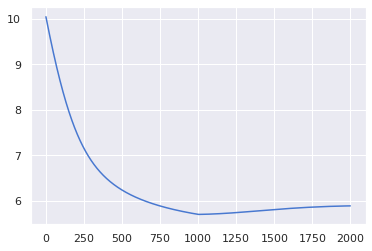

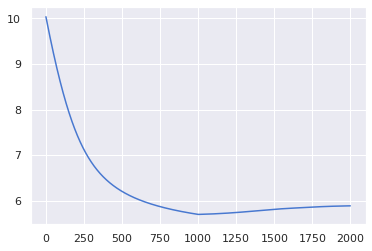

Gender agreement, 5 latent variable


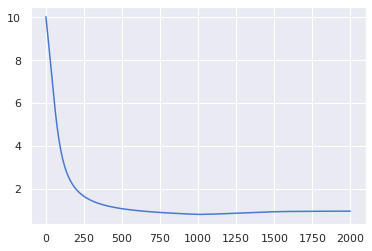

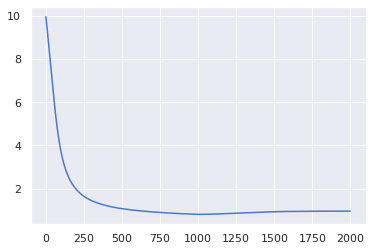

Person agreement, 5 latent variable


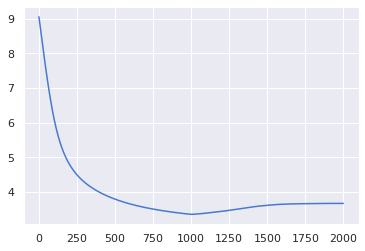

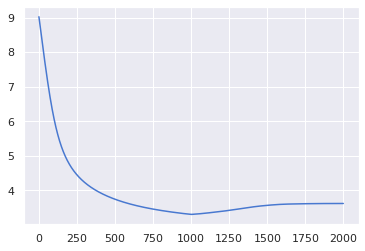

Number agreement, 5 latent variable


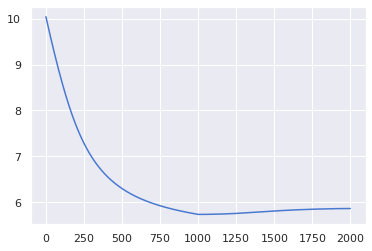

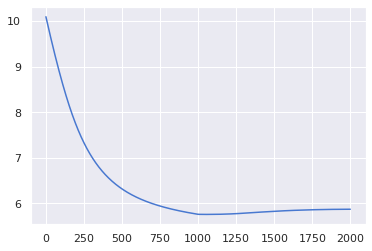

Gender agreement, 5 latent variable


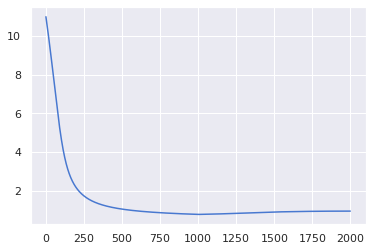

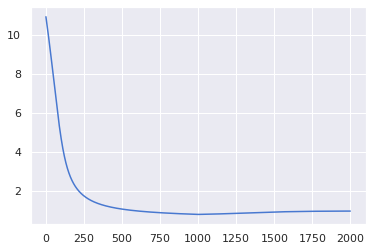

Person agreement, 5 latent variable


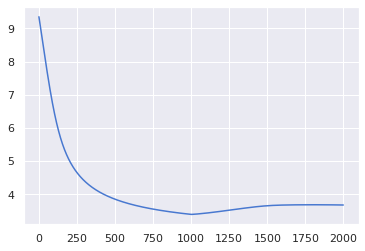

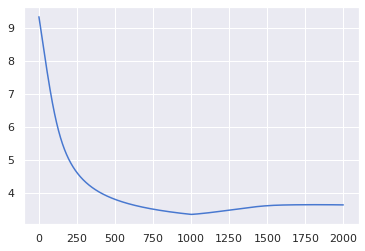

Number agreement, 5 latent variable


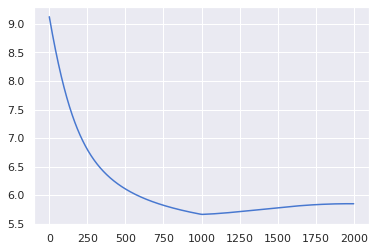

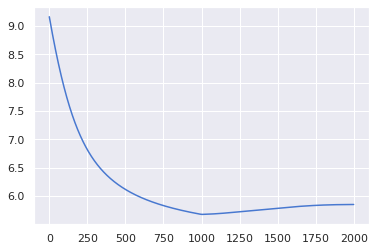

Gender agreement, 5 latent variable


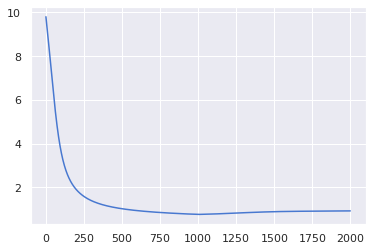

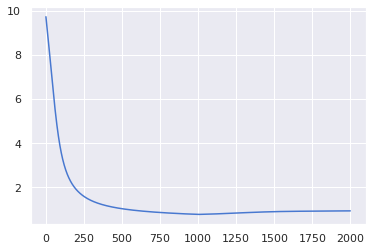

Person agreement, 5 latent variable


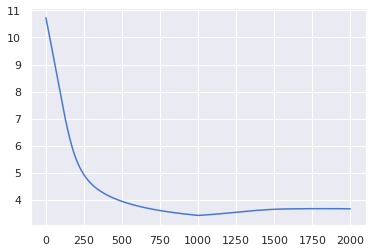

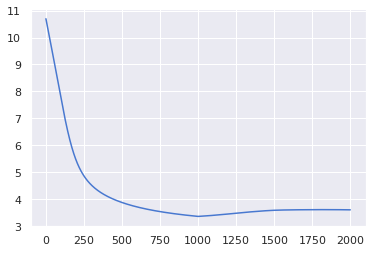

Number agreement, 5 latent variable


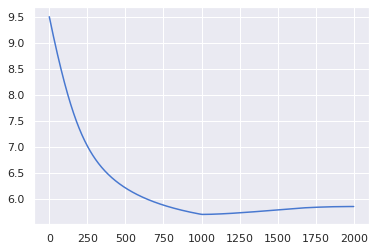

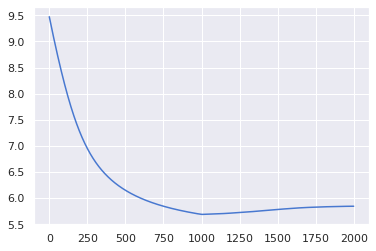

Gender agreement, 5 latent variable


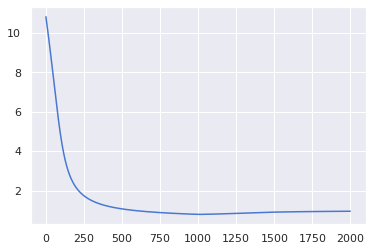

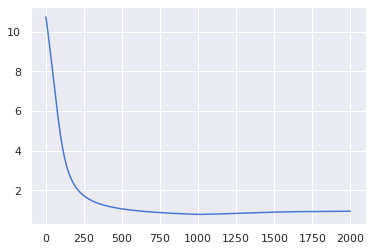

Person agreement, 5 latent variable


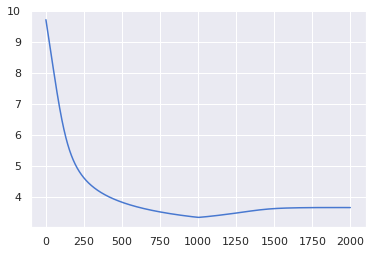

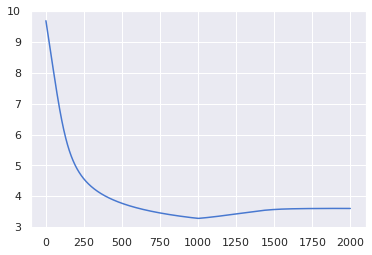

Number agreement, 5 latent variable


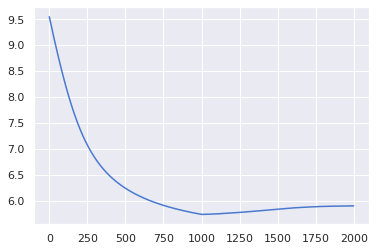

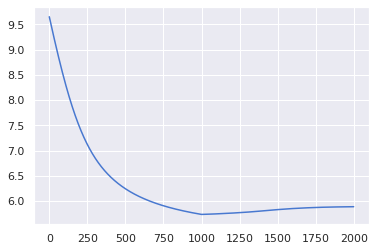

Gender agreement, 5 latent variable


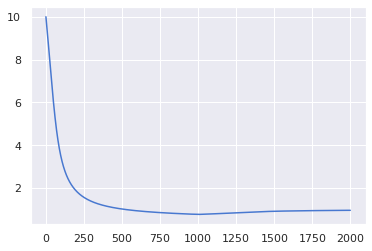

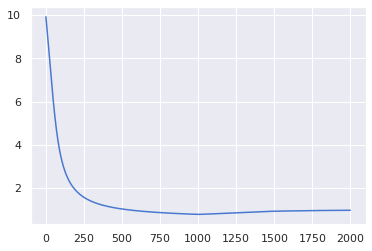

Person agreement, 5 latent variable


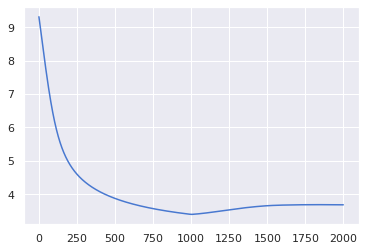

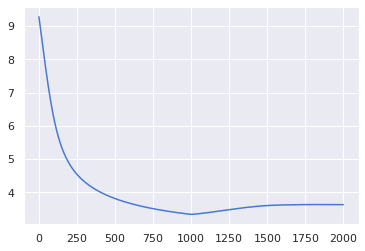

In [22]:
# No. latent variables = 5
rule_number_5 = {}
rule_gender_5 = {}
rule_person_5 = {}

for epoch in range(20):
    # Number agreement
    print('Number agreement, 5 latent variable')
    sbn_number_5 = fun.AdaSBN(n_latent = 5 , n_observed_binary = 1, n_observed_discrete = len_discrete_number)
    sbn_number_5.to(device)
    binary_weight_number_5, binary_bias_number_5, discrete_weight_number_5, discrete_bias_number_5, liklihood_number_5 = fun.training_process (reg_weight = 0.0005, proximal = True,binary_data = number_agreement, discrete_data = discrete_number, sbn_adaptive = sbn_number_5, valid_binary_data = valid_number_agreement, valid_discrete_data = valid_discrete_number)
    pd_binary_number_5, pd_discrete_full_number_5, pd_discrete_sparsity_number_5, pd_z_number_5 = fun.visual_result_new(binary_weight_number_5, binary_bias_number_5, discrete_weight_number_5, discrete_bias_number_5, 5, ['Number_agreement'], re_classes_number, sbn_number_5)
    for i in fun.possible_rules(pd_discrete_sparsity_number_5,pd_binary_number_5,5):
        rule_number_5[i] = rule_number_5.get(i,0) + 1


    # Gender agreement
    print('Gender agreement, 5 latent variable')
    sbn_gender_5 = fun.AdaSBN(n_latent = 5, n_observed_binary = 1, n_observed_discrete = len_discrete_gender)
    sbn_gender_5.to(device)
    binary_weight_gender_5, binary_bias_gender_5, discrete_weight_gender_5, discrete_bias_gender_5, liklihood_gender_5 = fun.training_process (reg_weight = 0.0009, proximal = True,binary_data = gender_agreement, discrete_data = discrete_gender, sbn_adaptive = sbn_gender_5, valid_binary_data = valid_gender_agreement, valid_discrete_data = valid_discrete_gender)
    pd_binary_gender_5, pd_discrete_full_gender_5, pd_discrete_sparsity_gender_5, pd_z_gender_5 = fun.visual_result_new(binary_weight_gender_5, binary_bias_gender_5, discrete_weight_gender_5, discrete_bias_gender_5, 5, ['Gender_agreement'], re_classes_gender, sbn_gender_5)
    for i in fun.possible_rules(pd_discrete_sparsity_gender_5,pd_binary_gender_5,5):
        rule_gender_5[i] = rule_gender_5.get(i,0) + 1


    # Person agreement
    print('Person agreement, 5 latent variable')
    sbn_person_5 = fun.AdaSBN(n_latent = 5 , n_observed_binary = 1, n_observed_discrete = len_discrete_person)
    sbn_person_5.to(device)
    binary_weight_person_5, binary_bias_person_5, discrete_weight_person_5, discrete_bias_person_5, liklihood_person_5 = fun.training_process (reg_weight = 0.0009, proximal = True,binary_data = person_agreement, discrete_data = discrete_person, sbn_adaptive = sbn_person_5, valid_binary_data = valid_person_agreement, valid_discrete_data = valid_discrete_person)
    pd_binary_person_5, pd_discrete_full_person_5, pd_discrete_sparsity_person_5, pd_z_person_5 = fun.visual_result_new(binary_weight_person_5, binary_bias_person_5, discrete_weight_person_5, discrete_bias_person_5, 5, ['Person_agreement'], re_classes_person, sbn_person_5)
    for i in fun.possible_rules(pd_discrete_sparsity_person_5,pd_binary_person_5,5):
        rule_person_5[i] = rule_person_5.get(i,0) + 1

    #print('All agreement')
    # All the features exists same time
    #sbn_all = fun.AdaSBN(n_latent = 5, n_observed_binary = 1, n_observed_discrete = len_discrete_all)
    #sbn_all.to(device)
    #binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all,  liklihood_all = fun.training_process (reg_weight = 0.0008, proximal = True,binary_data = all_agreement, discrete_data = discrete_all, sbn_adaptive = sbn_all, valid_binary_data = valid_all_agreement, valid_discrete_data = valid_discrete_all)
    #pd_binary_all, pd_discrete_full_all, pd_discrete_sparsity_all, pd_z_all = fun.visual_result_new(binary_weight_all, binary_bias_all, discrete_weight_all, discrete_bias_all, 5, ['All_agreement'], re_classes_all, sbn_all)
    #print(pd_binary_all, pd_discrete_sparsity_all, pd_z_all)
    #rule_all_5 = set(fun.possible_rules(pd_discrete_sparsity_all,pd_binary_all,5))
    #print('possible_rules:', rule_all_5)

In [31]:
# Fisher's exact test

# Number agreement 
print('Number_1:', fun.fisher_test({k:v for k,v in rule_number_1.items() if v>=4}.keys(), train_number, 'Number_head', 'Number_mod'))
print('Number_3:', fun.fisher_test({k:v for k,v in rule_number_3.items() if v>=4}.keys(), train_number, 'Number_head', 'Number_mod'))
print('Number_5:', fun.fisher_test({k:v for k,v in rule_number_5.items() if v>=4}.keys(), train_number, 'Number_head', 'Number_mod'))

# Gender agreement 
print('Gender_1:', fun.fisher_test({k:v for k,v in rule_gender_1.items() if v>=4}.keys(), train_gender, 'Gender_head', 'Gender_mod'))
print('Gender_3:', fun.fisher_test({k:v for k,v in rule_gender_3.items() if v>=4}.keys(), train_gender, 'Gender_head', 'Gender_mod'))
print('Gender_5:', fun.fisher_test({k:v for k,v in rule_gender_5.items() if v>=4}.keys(), train_gender, 'Gender_head', 'Gender_mod'))

# Person agreement 
print('Person_1:', fun.fisher_test({k:v for k,v in rule_person_1.items() if v>=4}.keys(), train_person, 'Person_head', 'Person_mod'))
print('Person_3:', fun.fisher_test({k:v for k,v in rule_person_3.items() if v>=4}.keys(), train_person, 'Person_head', 'Person_mod'))
print('Person_5:', fun.fisher_test({k:v for k,v in rule_person_5.items() if v>=4}.keys(), train_person, 'Person_head', 'Person_mod'))

Number_1: {}
Number_3: {('VERB_Head', 'PRON_Modifier', 'subj_Relation'): (1.4556923076923076e+02, 1.4892470489202167e-69)}
Number_5: {('VERB_Head', 'NOUN_Modifier', 'subj_Relation'): (1.884414806406861e+01, 3.221552467718329e-116), ('AUX_Head', 'PRON_Modifier', 'subj_Relation'): (159.95, 2.6696318430111293e-11), ('AUX_Head', 'NOUN_Modifier', 'subj_Relation'): (4.504023368606702, 1.6732292281414374e-13), ('VERB_Head', 'PRON_Modifier', 'subj_Relation'): (145.56923076923076, 1.4892470489202167e-69)}
Gender_1: {}
Gender_3: {}
Gender_5: {}
Person_1: {}
Person_3: {('VERB_Head', 'PRON_Modifier', 'subj_Relation'): (3.0658196721311474e+03, 6.855629143638773e-207), ('AUX_Head', 'PRON_Modifier', 'subj_Relation'): (237.6, 6.28033347624092e-15)}
Person_5: {('AUX_Head', 'PRON_Modifier', 'subj_Relation'): (2.376e+02, 6.28033347624092e-15), ('VERB_Head', 'PRON_Modifier', 'subj_Relation'): (3065.8196721311474, 6.855629143638773e-207)}


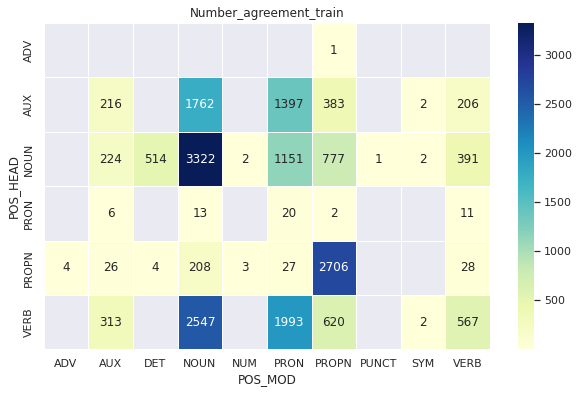

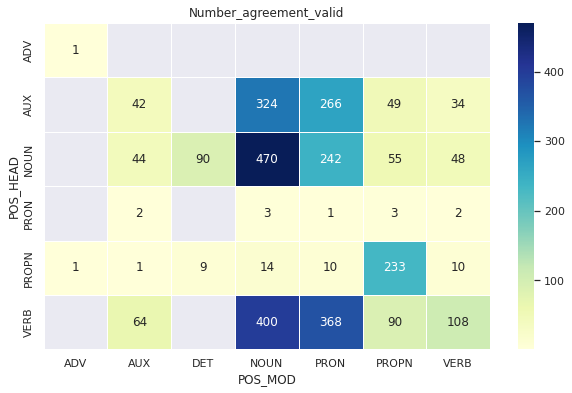

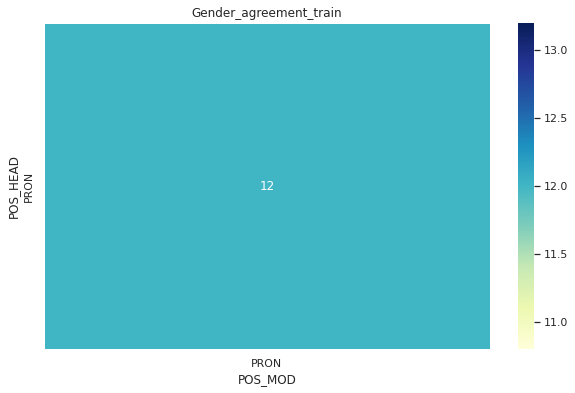

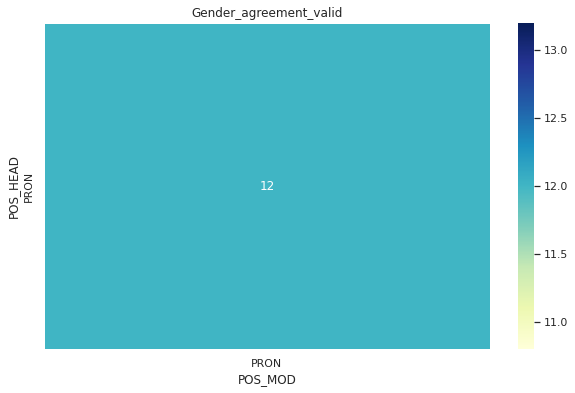

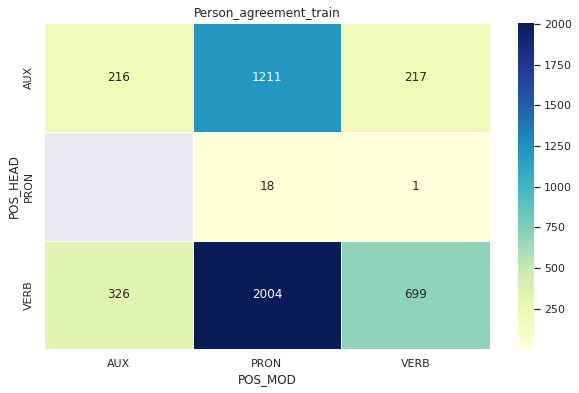

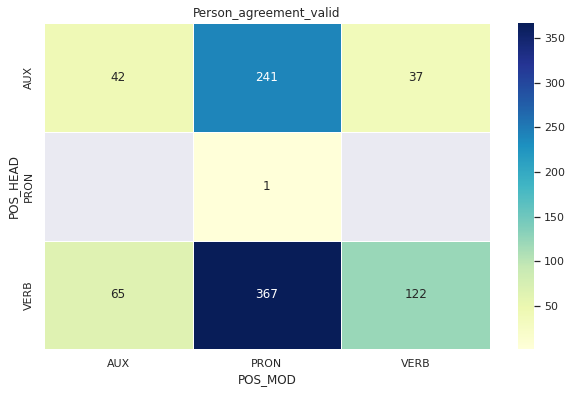

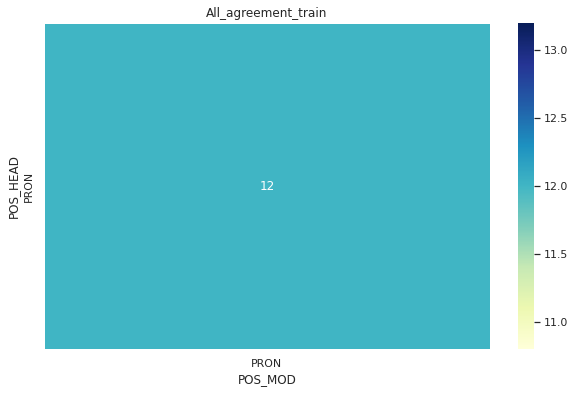

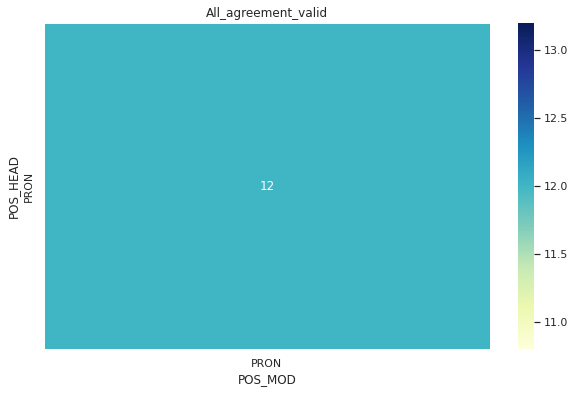

In [11]:
# explore the frequency of pos_head and pos_mod in different agreement eg. Noun_head and Det_mod occurs 47298 in number agreement
# Number agreement 
fun.pos_frequency(train_number, 'Number_agreement_train')
fun.pos_frequency(valid_number, 'Number_agreement_valid')
#plt.show()

# Gender agreement
fun.pos_frequency(train_gender, 'Gender_agreement_train')
fun.pos_frequency(valid_gender, 'Gender_agreement_valid')
#plt.show()


# Person agreement 
fun.pos_frequency(train_person, 'Person_agreement_train')
fun.pos_frequency(valid_person, 'Person_agreement_valid')
#plt.show()

# All agreement
fun.pos_frequency(train_all,'All_agreement_train')
fun.pos_frequency(valid_all,'All_agreement_valid')
#plt.show()


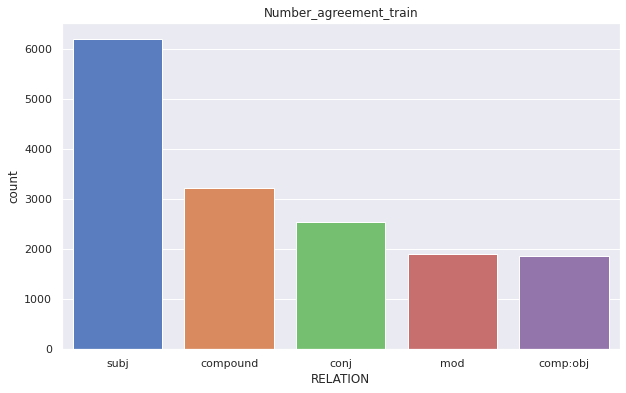

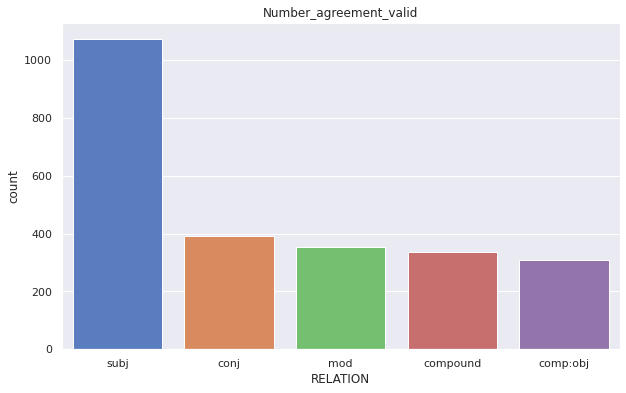

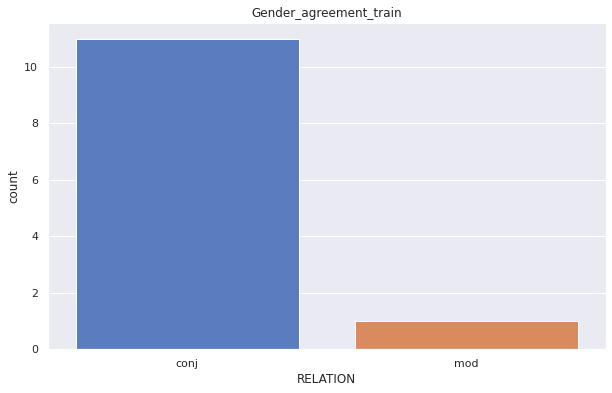

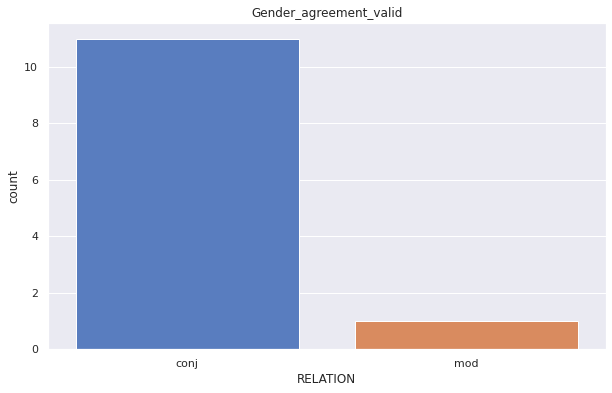

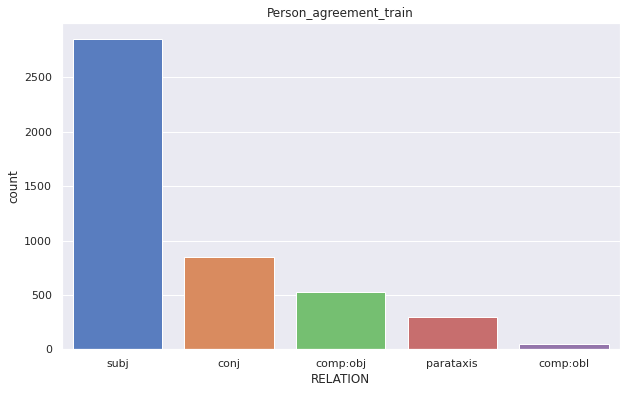

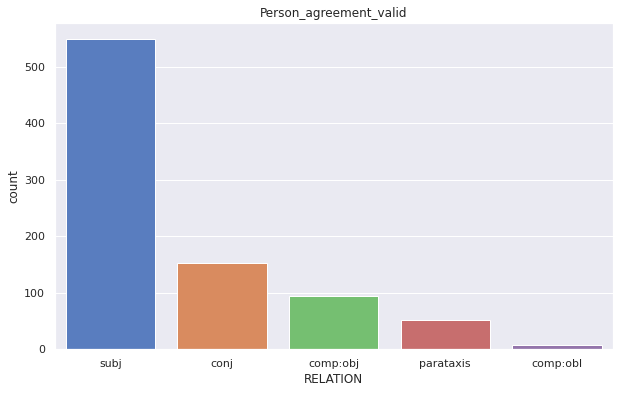

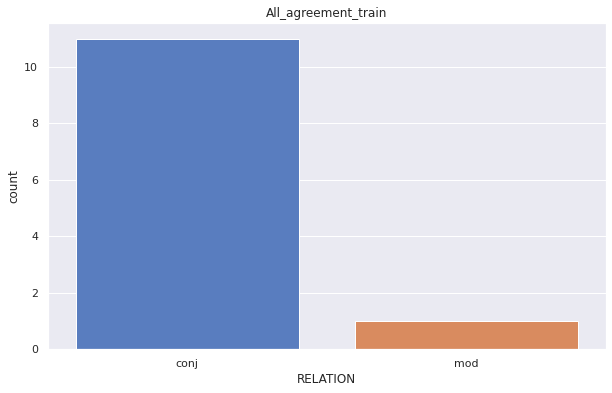

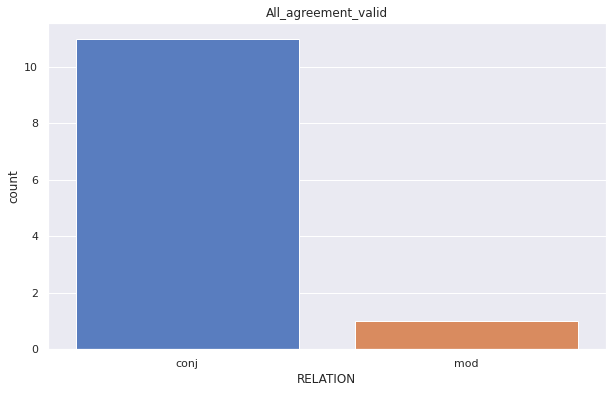

In [12]:
# Frequency of relation labels
# Number agreement 
fun.relation_frequency(train_number, 'Number_agreement_train')
fun.relation_frequency(valid_number, 'Number_agreement_valid')
#plt.show()

# Gender agreement
fun.relation_frequency(train_gender, 'Gender_agreement_train')
fun.relation_frequency(valid_gender, 'Gender_agreement_valid')
#plt.show()


# Person agreement 
fun.relation_frequency(train_person, 'Person_agreement_train')
fun.relation_frequency(valid_person, 'Person_agreement_valid')
#plt.show()

# All agreement
fun.relation_frequency(train_all, 'All_agreement_train')
fun.relation_frequency(valid_all, 'All_agreement_valid')
#plt.show()

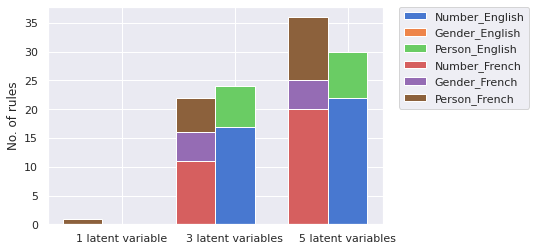

In [55]:
labels = ['1 latent variable', '3 latent variables', '5 latent variables']
number_en = [0, 17,22]
gender_en = [0, 0, 0]
person_en = [0,7,8]

number_fr = [0, 11, 20]
gender_fr = [0, 5, 5]
person_fr = [1, 6, 11]
x = np.arange(len(labels))  # the label locations

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, number_en, width, label='Number_English')
ax.bar(labels, gender_en, width, bottom=number_en,
       label='Gender_English')
ax.bar(labels, person_en, width, bottom=np.add(number_en, gender_en),
       label='Person_English')

rects1 = ax.bar(x-width, number_fr, width, label='Number_French')
rects2 = ax.bar(x-width, gender_fr, width, bottom=number_fr,
       label='Gender_French')
rects3 = ax.bar(x-width, person_fr, width, bottom=np.add(number_fr, gender_fr),
       label='Person_French')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of rules')
#ax.set_title('The number of total extracted rules in 20 times training')
ax.set_xticks(x, labels)

ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) 

#fig.tight_layout()

plt.show()

